# What do the pose dynamics look like before and after applying the model?

Can I give myself a sense of what the high and low r2 scores mean for the validation dataset?

In [64]:
import cv2
import h5py
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from ipywidgets import Video
from aging.video import write_movie
from aging.size_norm.data import clean, normalize, Session
from aging.size_norm.lightning import predict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cdist

In [11]:
def smooth_clean(frame):
    frame = clean(frame)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame

In [12]:
# grab a few examples
max_frames = 15_000
with h5py.File('/n/groups/datta/win/longtogeny/data/size_network/male_ontogeny_validation.h5', 'r') as h5f:
    keys = list(h5f['data'])
    x = h5f['data'][keys[0]][:max_frames]
    x_old = h5f['data'][keys[7]][:max_frames]
    x_young = h5f['data'][keys[8]][:max_frames]

clean_x = np.array([smooth_clean(frame) for frame in x])
clean_old = np.array([smooth_clean(frame) for frame in x_old])
clean_young = np.array([smooth_clean(frame) for frame in x_young])

In [5]:
param_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/size_network/analysis/param_scan_05_results.parquet')

In [8]:
worst, mid, best = param_df.sort_values(by='fit_beh_val')['file'].values[[0, len(param_df) // 2, -1]]

## Predictions

In [14]:
pred_output = {}
for mdl_type, mdl_path in zip(('worst', 'mid', 'best'), (worst, mid, best)):
    mdl = torch.jit.load(mdl_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    preds = tuple(predict(Session(x), mdl) for x in (x_young, x, x_old))
    pred_output[mdl_type] = preds

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
x_pca = PCA(n_components=10)
x_pcs = x_pca.fit_transform(clean_x.reshape(len(clean_x), -1))
x_pcs = StandardScaler().fit_transform(x_pcs)

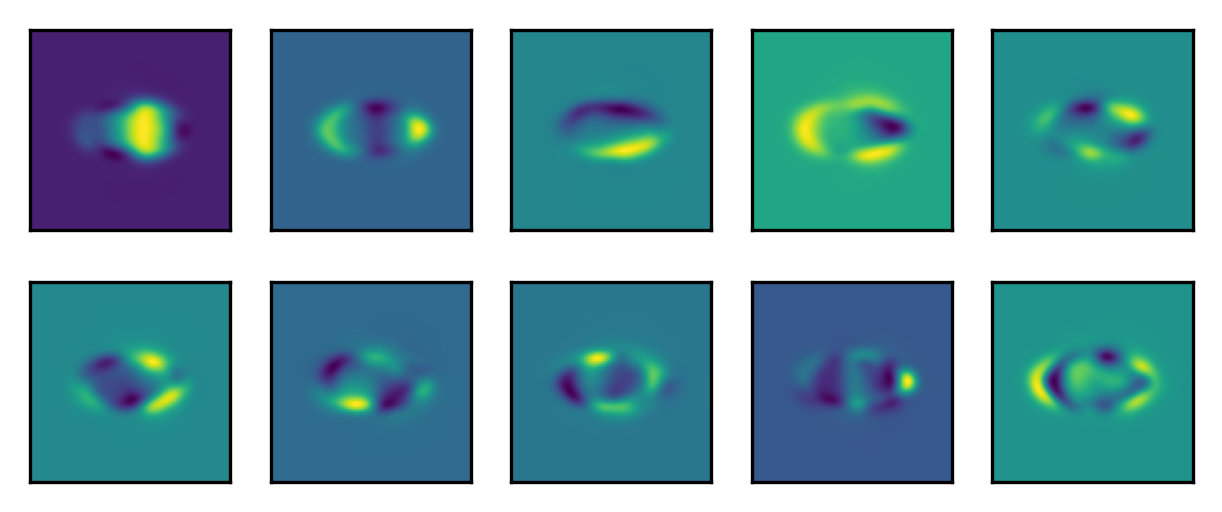

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(5, 2))
fig.dpi = 150
for a, comp in zip(ax.flat, x_pca.components_):
    a.imshow(comp.reshape(80, 80))
    a.set(yticks=[], xticks=[])

In [18]:
x_pcs.shape

(15000, 10)

In [19]:
list(pred_output)

['worst', 'mid', 'best']

In [30]:
pcs_output = {}
pca_dict = {}
pca = PCA(n_components=50)
scaler = StandardScaler()
for key, v in tqdm(pred_output.items()):
    pcs_output[key] = tuple(scaler.fit_transform(pca.fit_transform(pred.reshape(len(pred), -1))) for pred in v)
    pca_dict[key] = tuple(pca.fit(pred.reshape(len(pred), -1)).components_ for pred in v)

  0%|          | 0/3 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Worst')

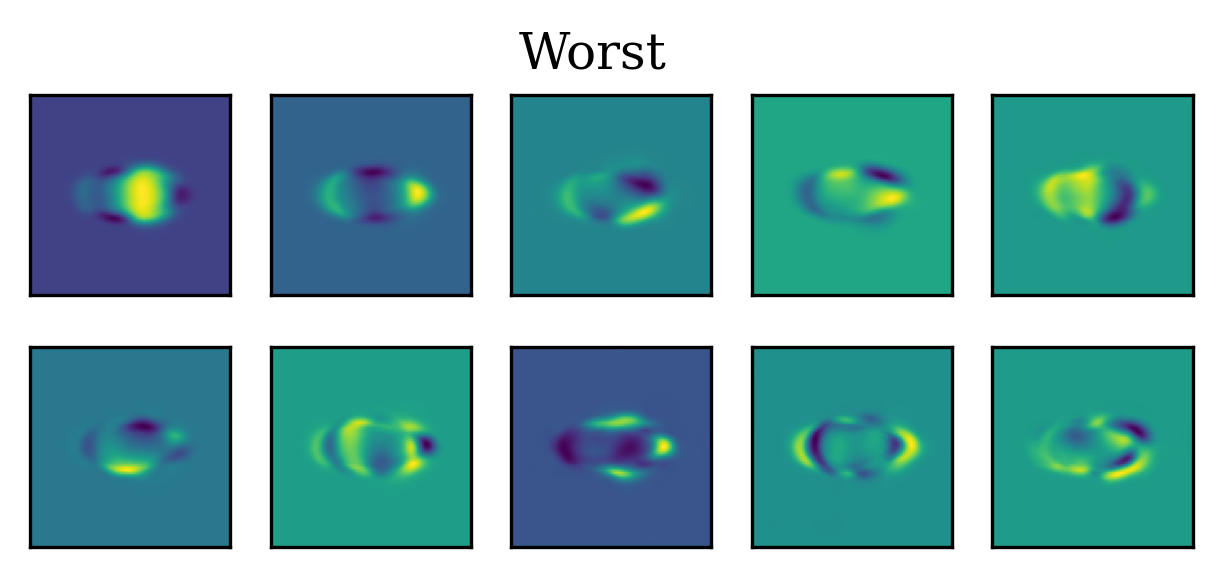

In [31]:
fig, ax = plt.subplots(2, 5, figsize=(5, 2))
fig.dpi = 150
for a, comp in zip(ax.flat, pca_dict['worst'][1]):
    a.imshow(comp.reshape(80, 80))
    a.set(yticks=[], xticks=[])
fig.suptitle("Worst")

In [90]:
from scipy.stats import wasserstein_distance

0.00043987550111352627


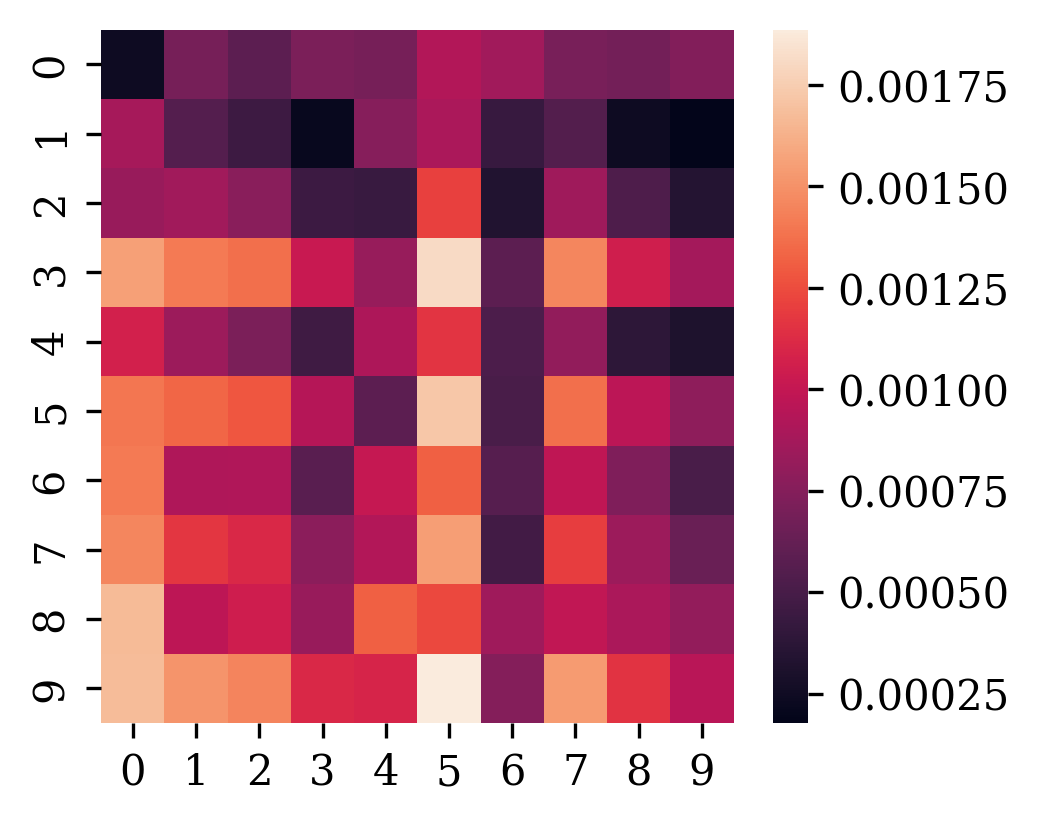

In [93]:
fig = plt.figure(figsize=(3.4, 3), dpi=150)
corr_dist = cdist(np.abs(x_pca.components_), np.abs(pca_dict['worst'][1][:10]), metric=wasserstein_distance)
sns.heatmap(corr_dist)#, vmin=0, vmax=2)
print(np.mean(corr_dist.min(1) + corr_dist.min(0)) / 2)

0.0008484368772332929


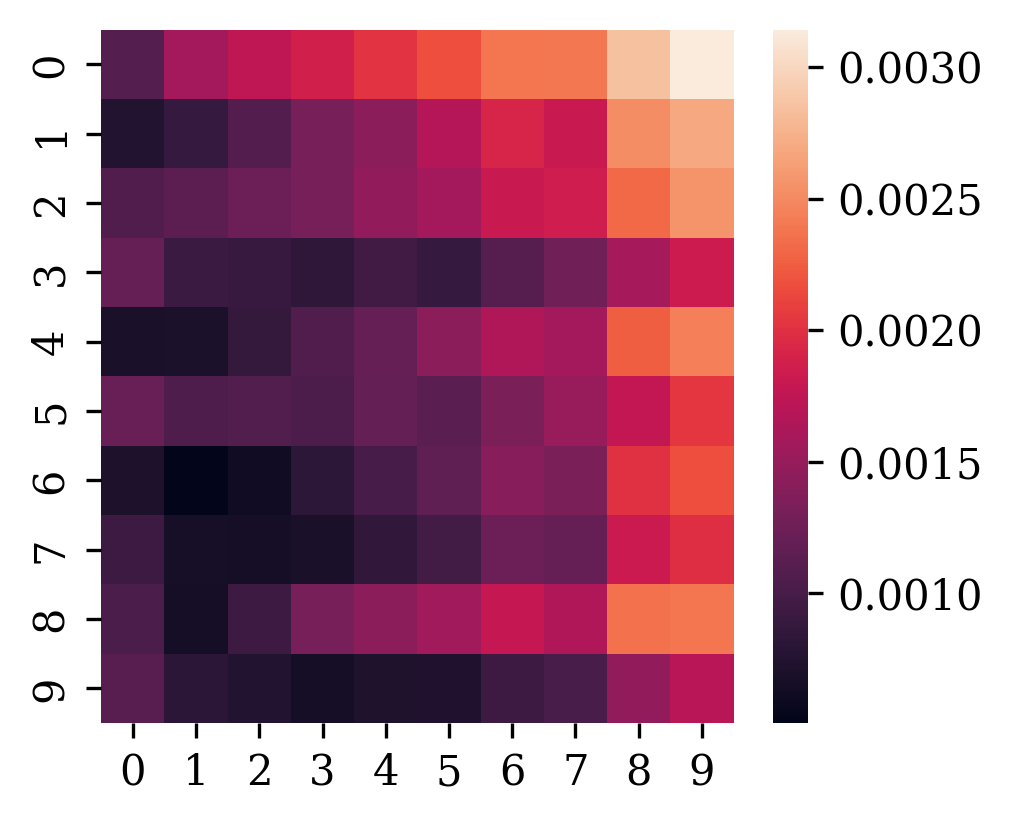

In [94]:
fig = plt.figure(figsize=(3.4, 3), dpi=150)
corr_dist = cdist(np.abs(x_pca.components_), np.abs(pca_dict['best'][1][:10]), metric=wasserstein_distance)
sns.heatmap(corr_dist)#, vmin=0, vmax=2)
print(np.mean(corr_dist.min(1) + corr_dist.min(0)) / 2)

Text(0.5, 0.98, 'Best')

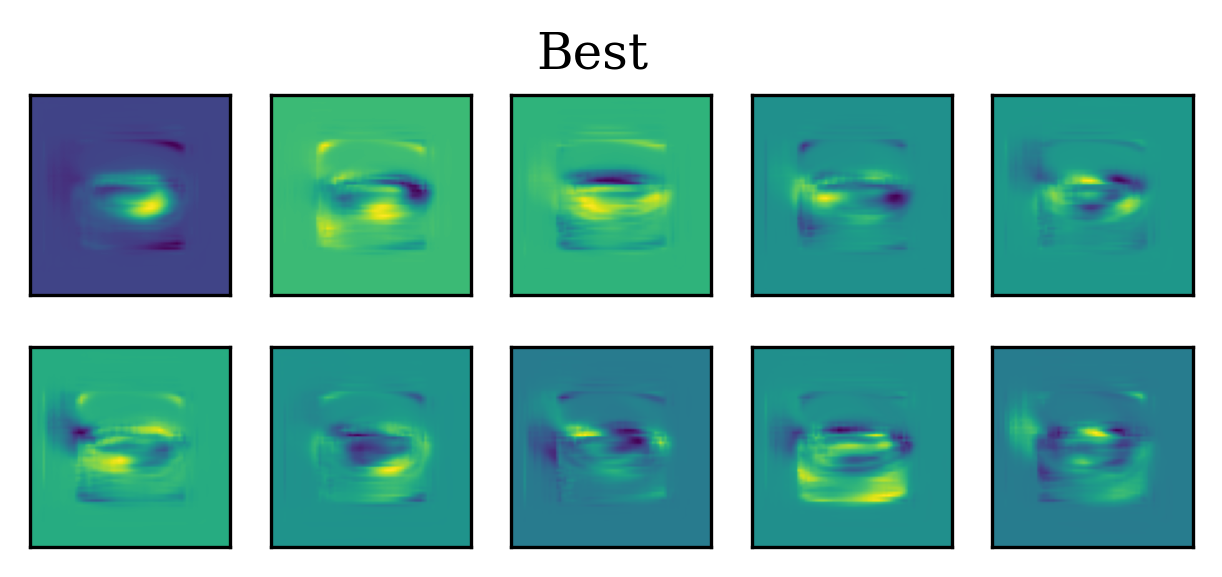

In [32]:
fig, ax = plt.subplots(2, 5, figsize=(5, 2))
fig.dpi = 150
for a, comp in zip(ax.flat, pca_dict['best'][1]):
    a.imshow(comp.reshape(80, 80))
    a.set(yticks=[], xticks=[])
fig.suptitle("Best")

In [35]:
mdl = LinearRegression()
mdl.fit(x_pcs, pcs_output['worst'][1])
worst_coef = mdl.coef_.copy()
mdl.fit(x_pcs, pcs_output['best'][1])
best_coef = mdl.coef_.copy()

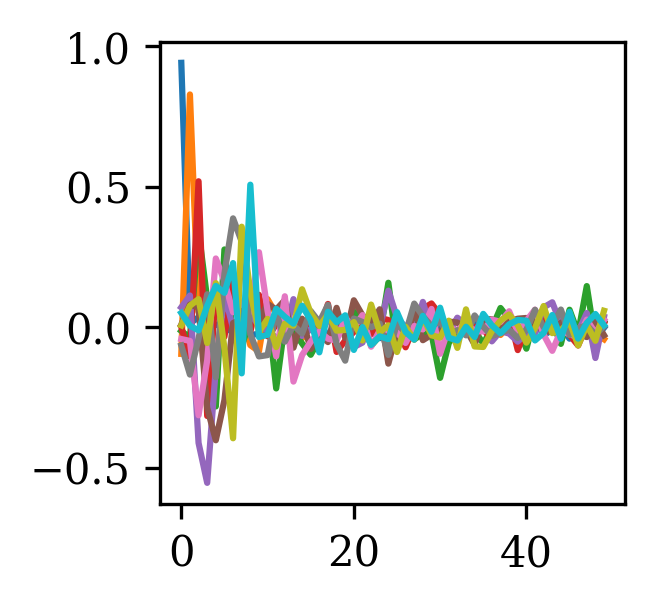

In [41]:
plt.figure(figsize=(2, 2), dpi=150)
plt.plot(worst_coef, label='worst');

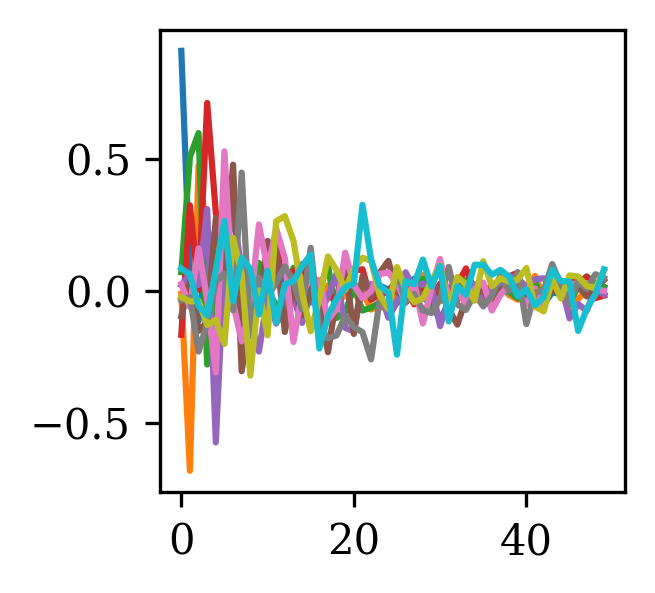

In [43]:
plt.figure(figsize=(2, 2), dpi=150)
plt.plot(best_coef, label='best');

0.439977412648448


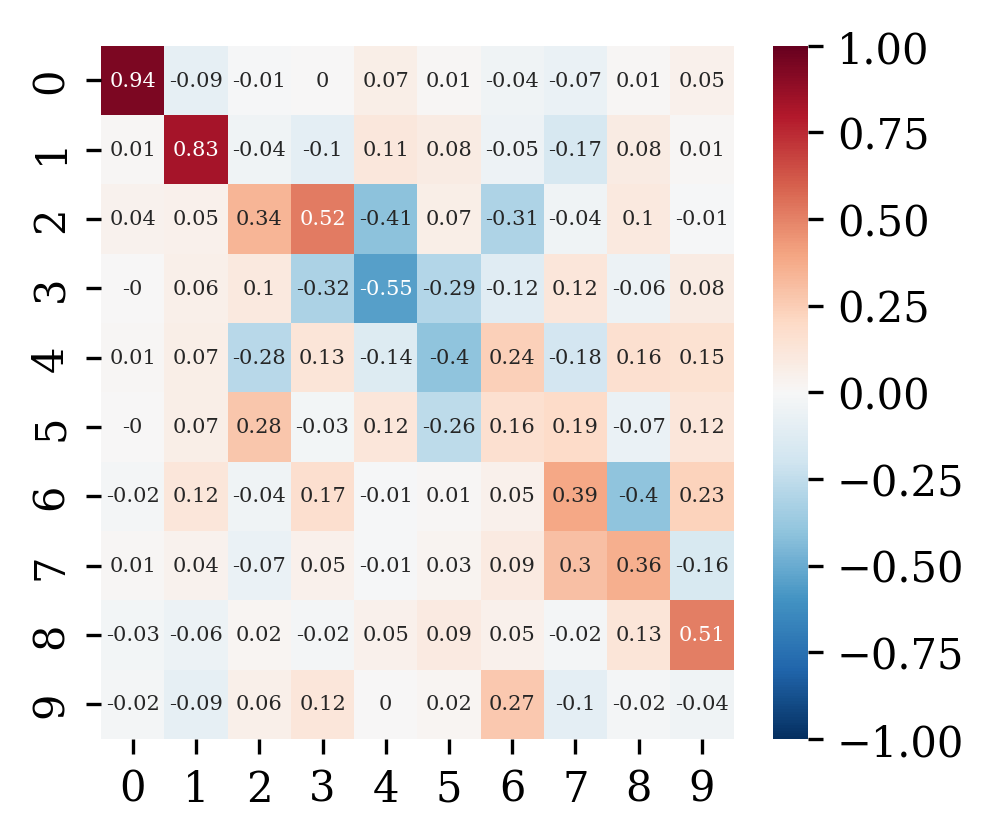

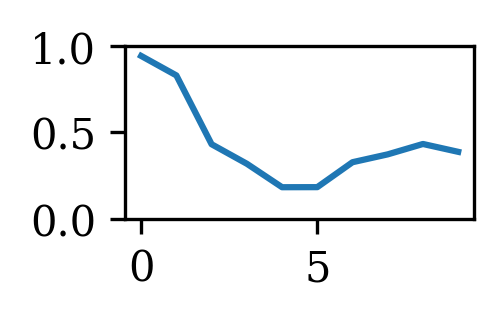

In [61]:
fig = plt.figure(figsize=(3.4, 3), dpi=150)
cc = np.corrcoef(x_pcs.T, pcs_output['worst'][1].T[:10])[10:, :10]
sns.heatmap(np.round(cc, 2), annot=True, cmap='RdBu_r', vmin=-1, vmax=1, annot_kws=dict(fontsize=5))
fig = plt.figure(figsize=(1.5, 0.75), dpi=150)
plt.plot((cc.max(1) + cc.max(0)) / 2)
plt.ylim(0, 1)
print(np.mean((cc.max(1) + cc.max(0)) / 2))

0.4857481845912607


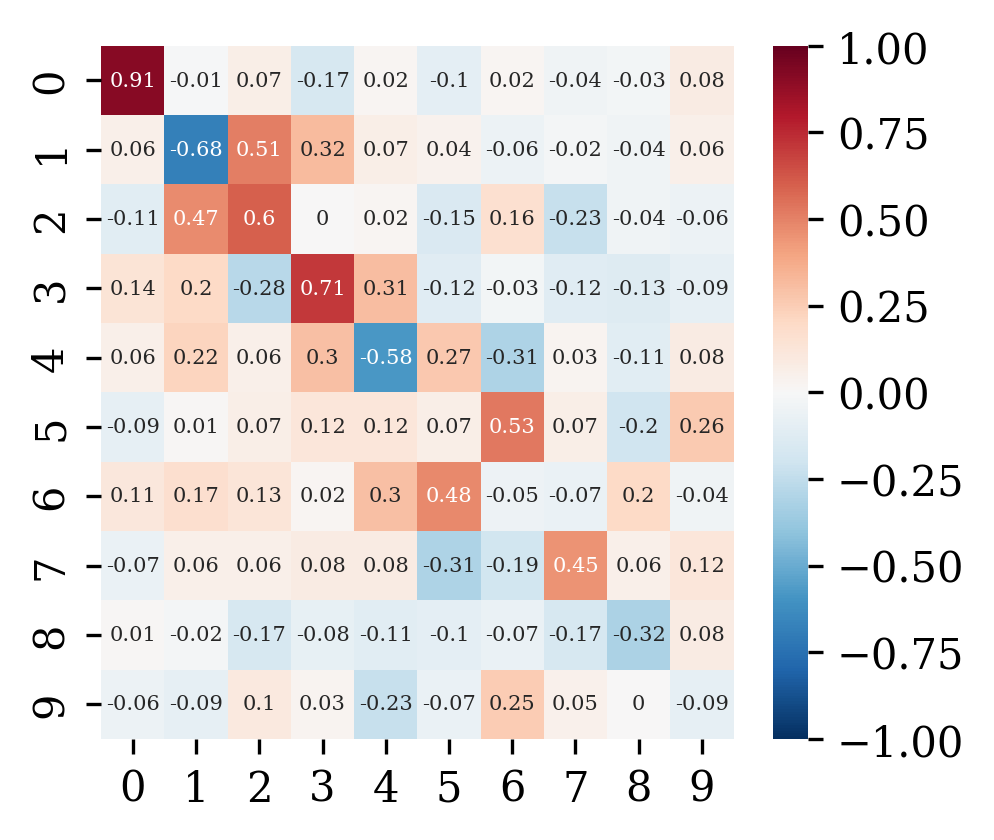

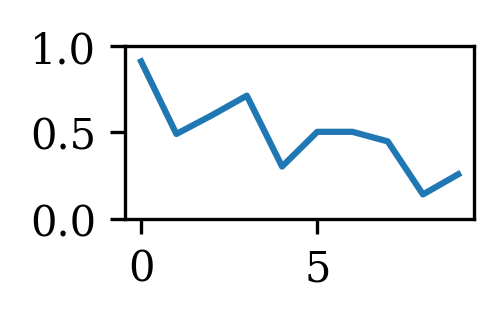

In [62]:
fig = plt.figure(figsize=(3.4, 3), dpi=150)
cc = np.corrcoef(x_pcs.T, pcs_output['best'][1].T[:10])[10:, :10]
sns.heatmap(np.round(cc, 2), annot=True, cmap='RdBu_r', vmin=-1, vmax=1, annot_kws=dict(fontsize=5))
fig = plt.figure(figsize=(1.5, 0.75), dpi=150)
plt.plot((cc.max(1) + cc.max(0)) / 2)
plt.ylim(0, 1)
print(np.mean((cc.max(1) + cc.max(0)) / 2))

## Movie sequences

In [ ]:
!mkdir -p /n/groups/datta/win/longtogeny/data/video/

In [24]:
_input = np.concatenate((clean_x, pred_output['worst'][1]), axis=2)

In [26]:
write_movie('/n/groups/datta/win/longtogeny/data/video/bad_mdl_example_01.mp4', _input[:2000])
Video.from_file('/n/groups/datta/win/longtogeny/data/video/bad_mdl_example_01.mp4', width=500)

In [33]:
_input = np.concatenate((clean_x, pred_output['best'][1]), axis=2)

In [34]:
write_movie('/n/groups/datta/win/longtogeny/data/video/good_mdl_example_01.mp4', _input[:2000])
Video.from_file('/n/groups/datta/win/longtogeny/data/video/good_mdl_example_01.mp4', width=500)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', width='500')

### Linear regression for best model

In [115]:
x_pca = PCA(n_components=10)
x_pcs = x_pca.fit_transform(clean_x.reshape(len(clean_x), -1))
x_pcs = StandardScaler().fit_transform(x_pcs)

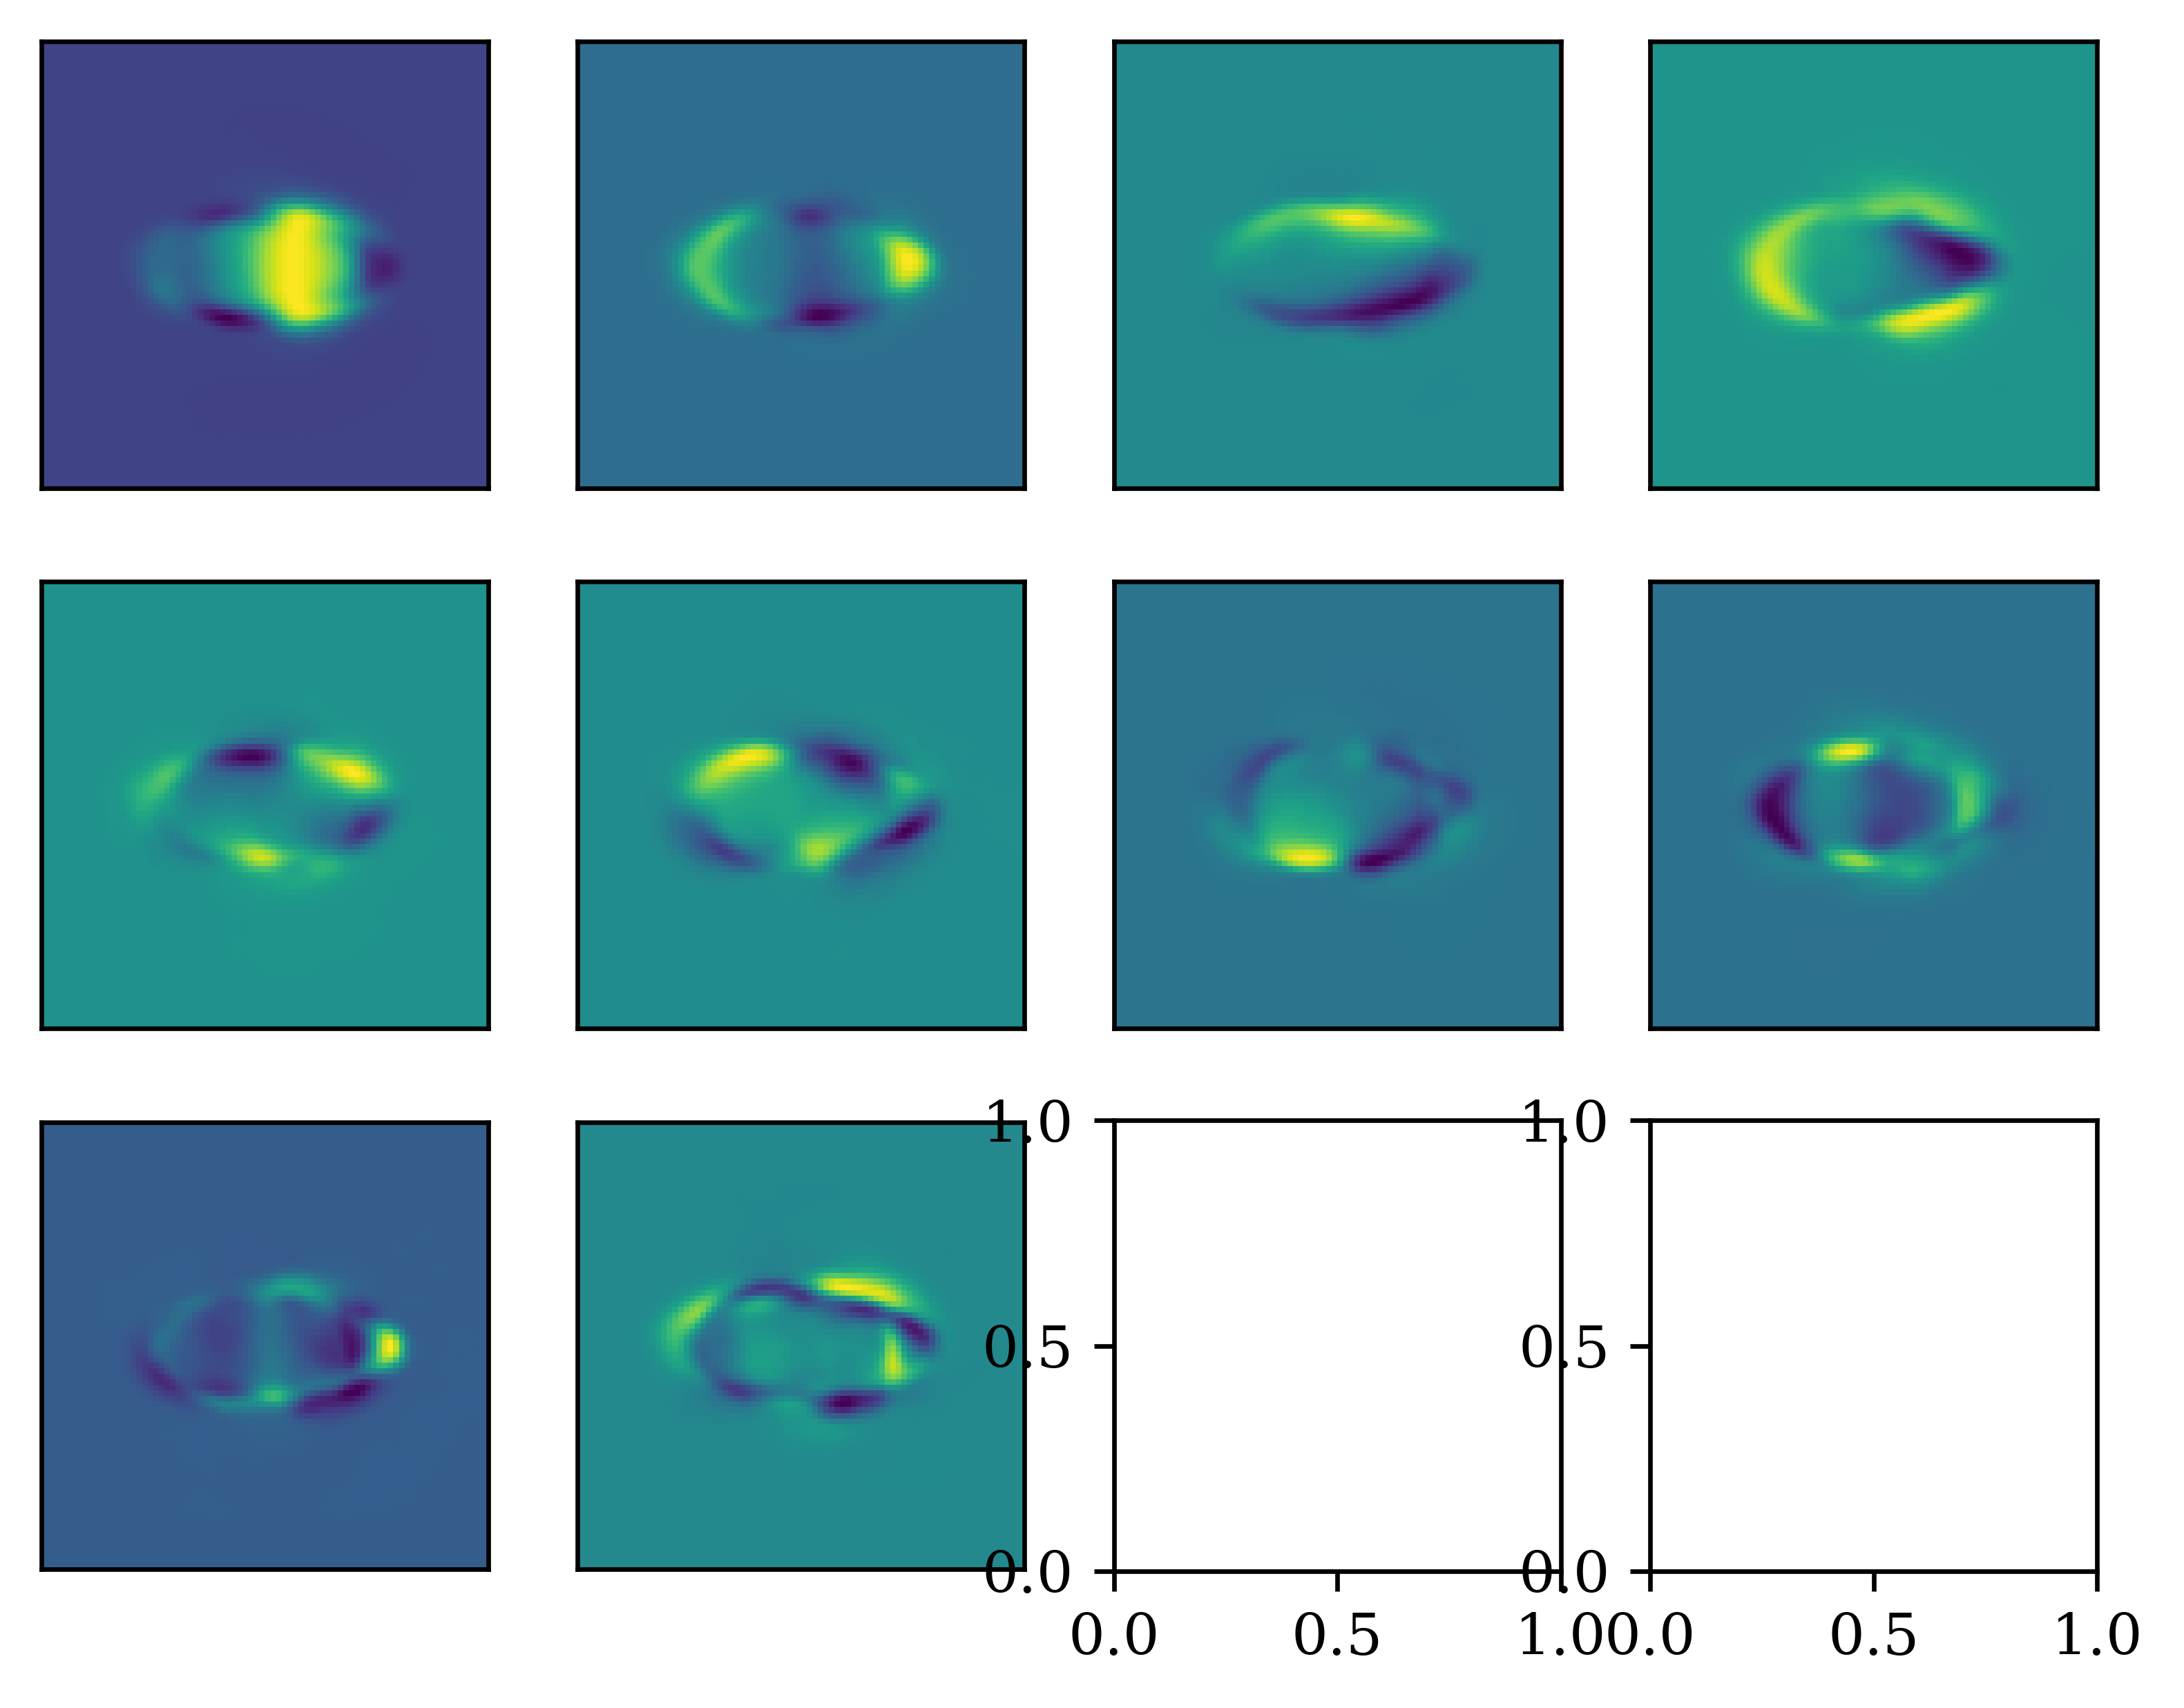

In [116]:
fig, ax = plt.subplots(3, 4)
for a, comp in zip(ax.flat, x_pca.components_):
    a.imshow(comp.reshape(80, 80))
    a.set(yticks=[], xticks=[])

In [117]:
x_pcs.shape

(10000, 10)

In [118]:
best_pred_pcs = PCA(n_components=50).fit_transform(best_pred_x.reshape(len(best_pred_x), -1))
best_pred_pcs = StandardScaler().fit_transform(best_pred_pcs)

In [161]:
mdl = ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=2000)
# mdl = LinearRegression()
mdl.fit(best_pred_pcs, x_pcs)

ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=2000)

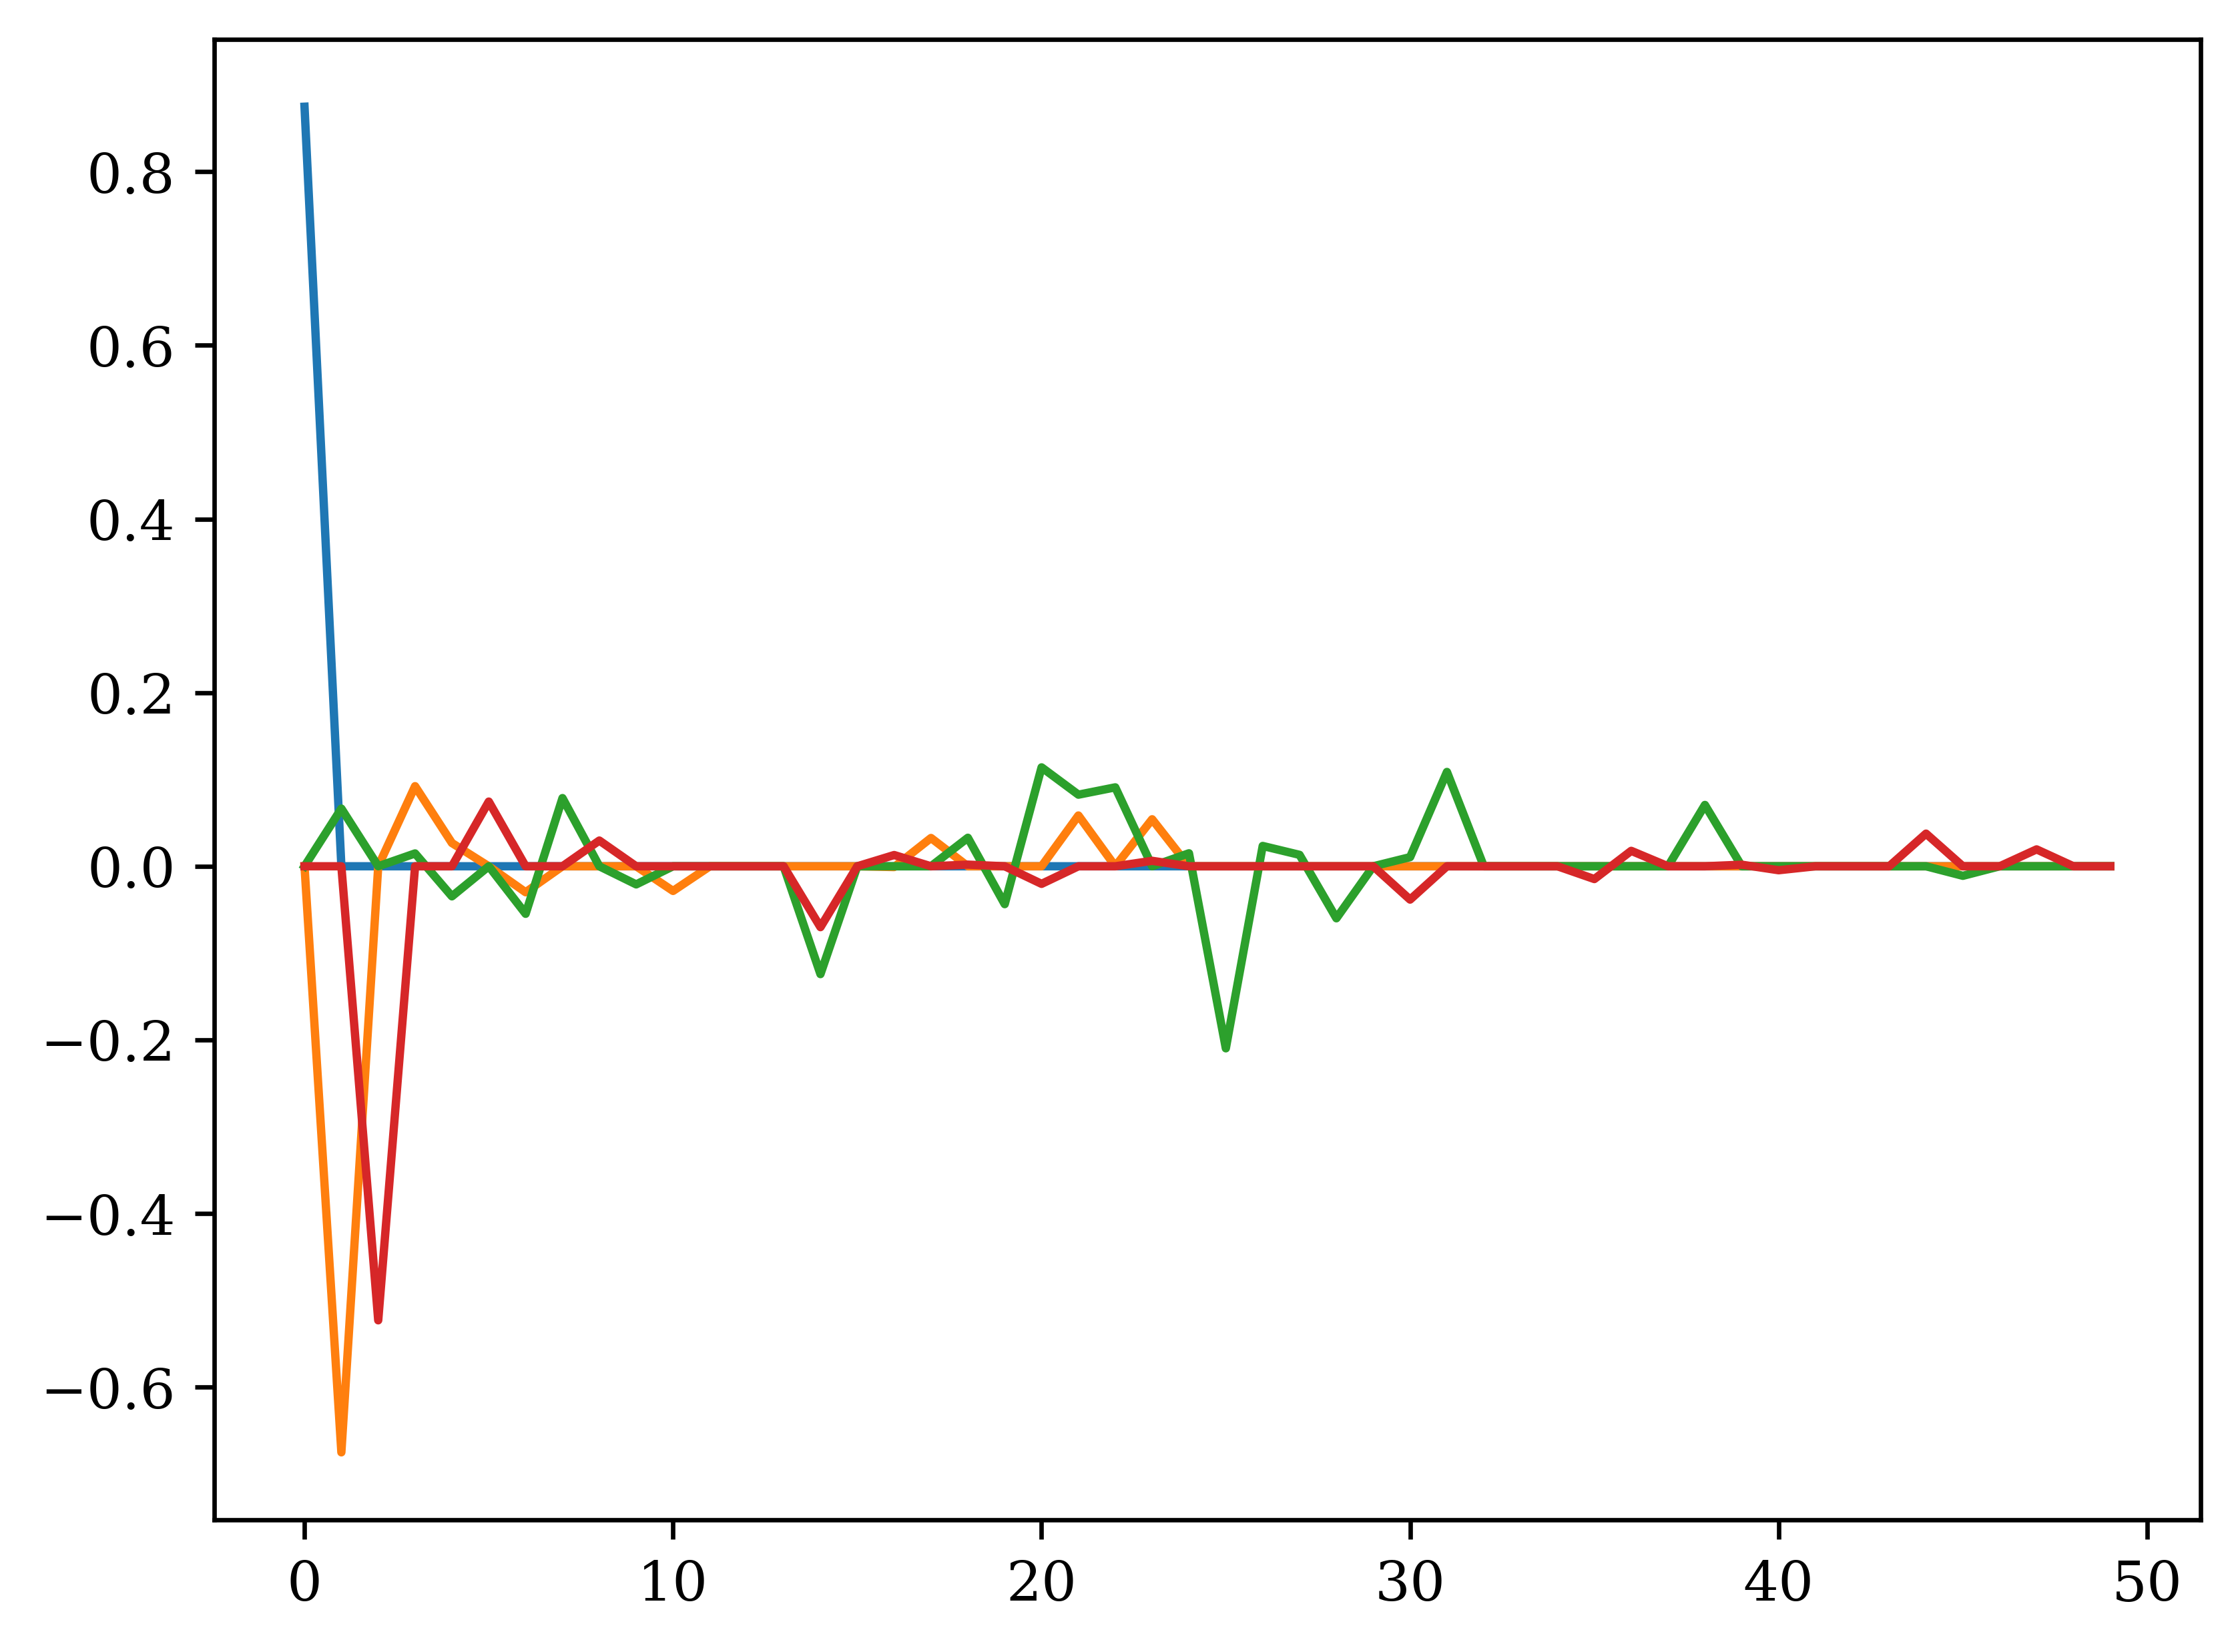

In [162]:
plt.plot(mdl.coef_[0])
plt.plot(mdl.coef_[1])
plt.plot(mdl.coef_[2])
plt.plot(mdl.coef_[3])

In [163]:
pcs_pred = mdl.predict(best_pred_pcs)

<Axes: >

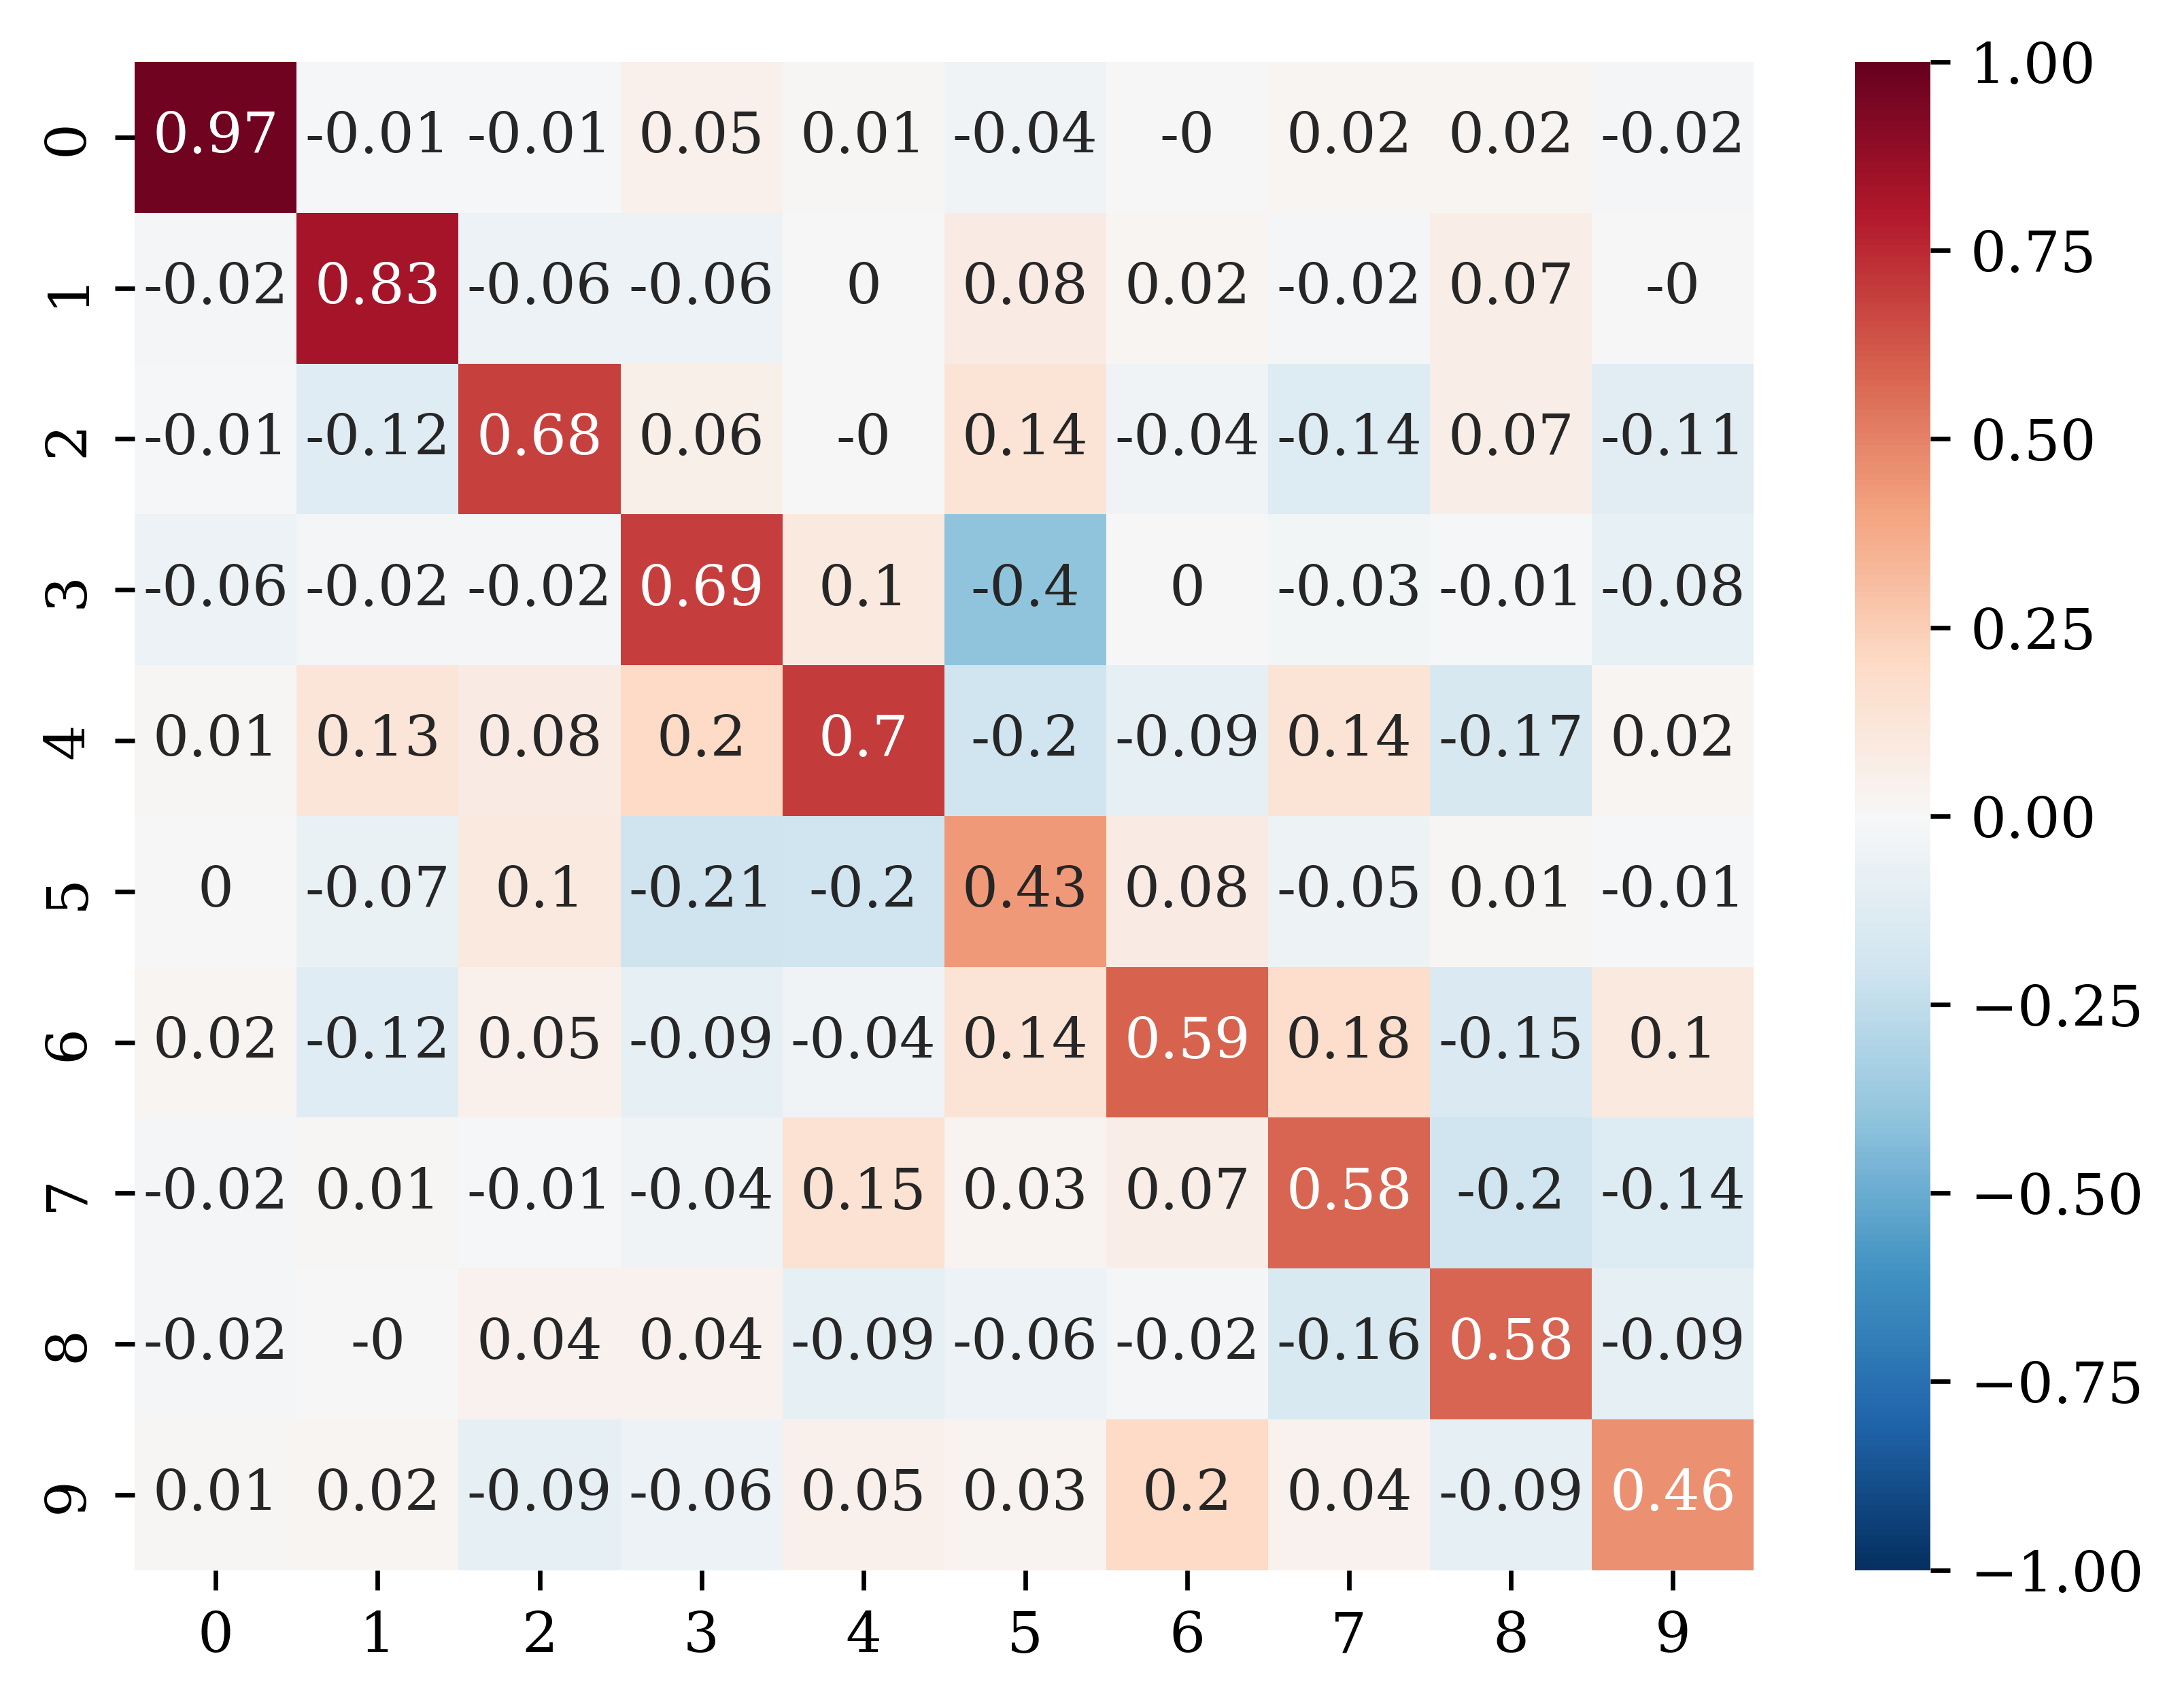

In [164]:
cc = np.round(np.corrcoef(pcs_pred.T, x_pcs.T)[10:, :10], 2)
sns.heatmap(cc, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)

In [165]:
np.diag(cc).mean()

0.651

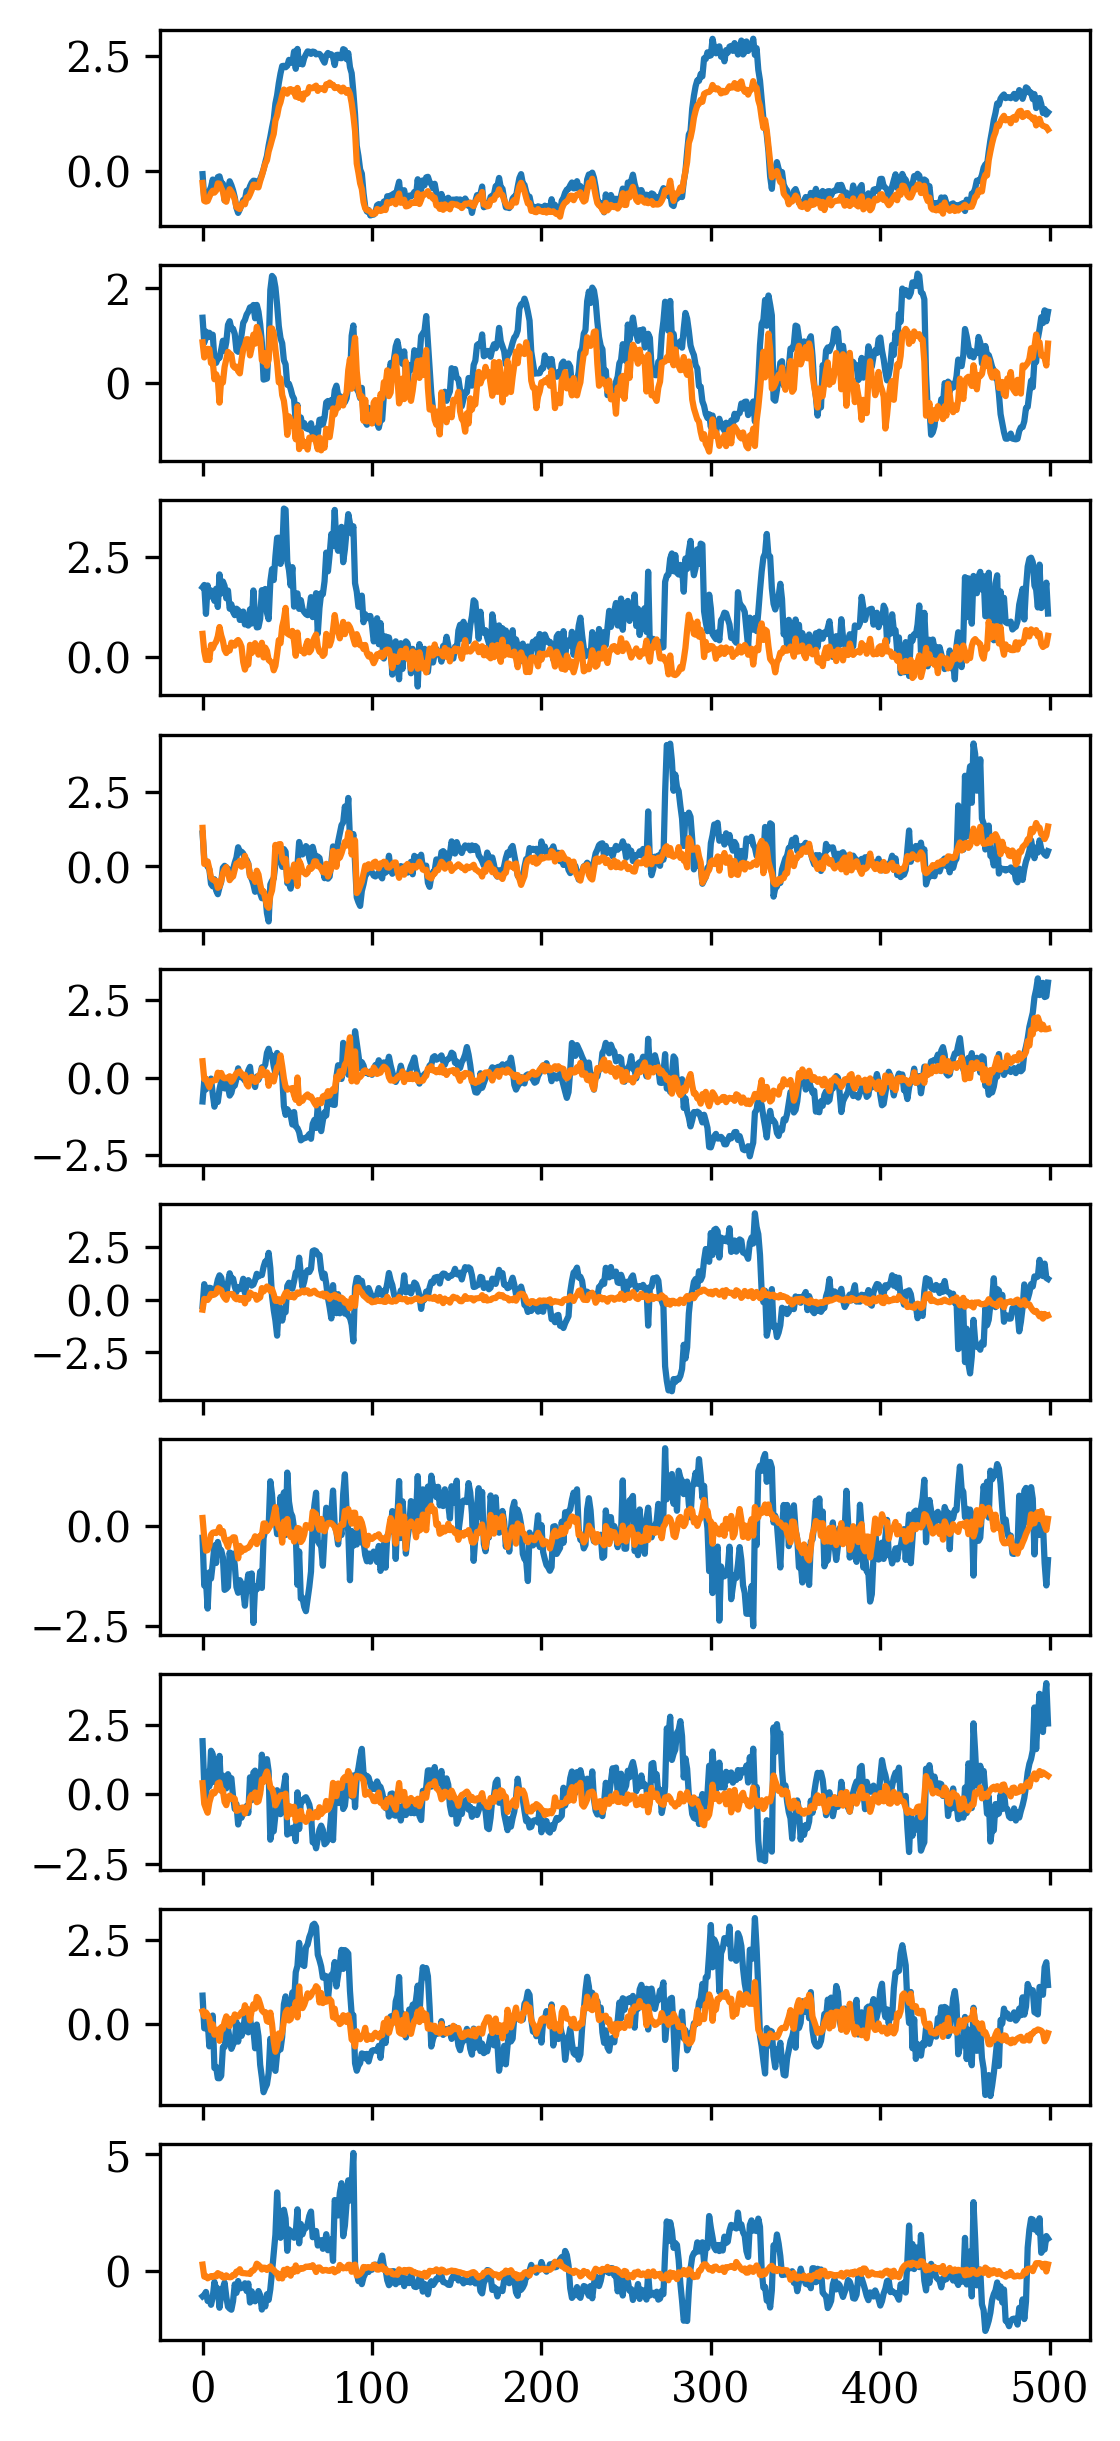

In [133]:
fig, ax = plt.subplots(10, 1, sharex=True, figsize=(4, 10))
fig.dpi = 150
for ind, a in enumerate(ax.flat):
    a.plot(x_pcs[:500, ind])
    a.plot(pcs_pred[:500, ind])

## Other model

In [3]:
mdl = torch.jit.load('/n/groups/datta/win/longtogeny/size_norm/models/testing_02/model.pt', map_location='cuda')

best_pred_x = predict(Session(x), mdl)
best_pred_x2 = predict(Session(x2), mdl)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [75]:
_input = np.concatenate((clean_x, best_pred_x), axis=2)

In [76]:
write_movie('/n/groups/datta/win/longtogeny/data/video/other_mdl_example_01.mp4', _input)

In [3]:
Video.from_file('/n/groups/datta/win/longtogeny/data/video/other_mdl_example_01.mp4', width=500)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', width='500')

In [78]:
_input = np.concatenate((clean_x2, best_pred_x2), axis=2)

In [79]:
write_movie('/n/groups/datta/win/longtogeny/data/video/other_mdl_example_02.mp4', _input)

In [80]:
Video.from_file('/n/groups/datta/win/longtogeny/data/video/other_mdl_example_02.mp4', width=500)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', width='500')

### Linear regression for best model

In [4]:
x_pca = PCA(n_components=10)
x_pcs = x_pca.fit_transform(clean_x.reshape(len(clean_x), -1))
x_pcs = StandardScaler().fit_transform(x_pcs)

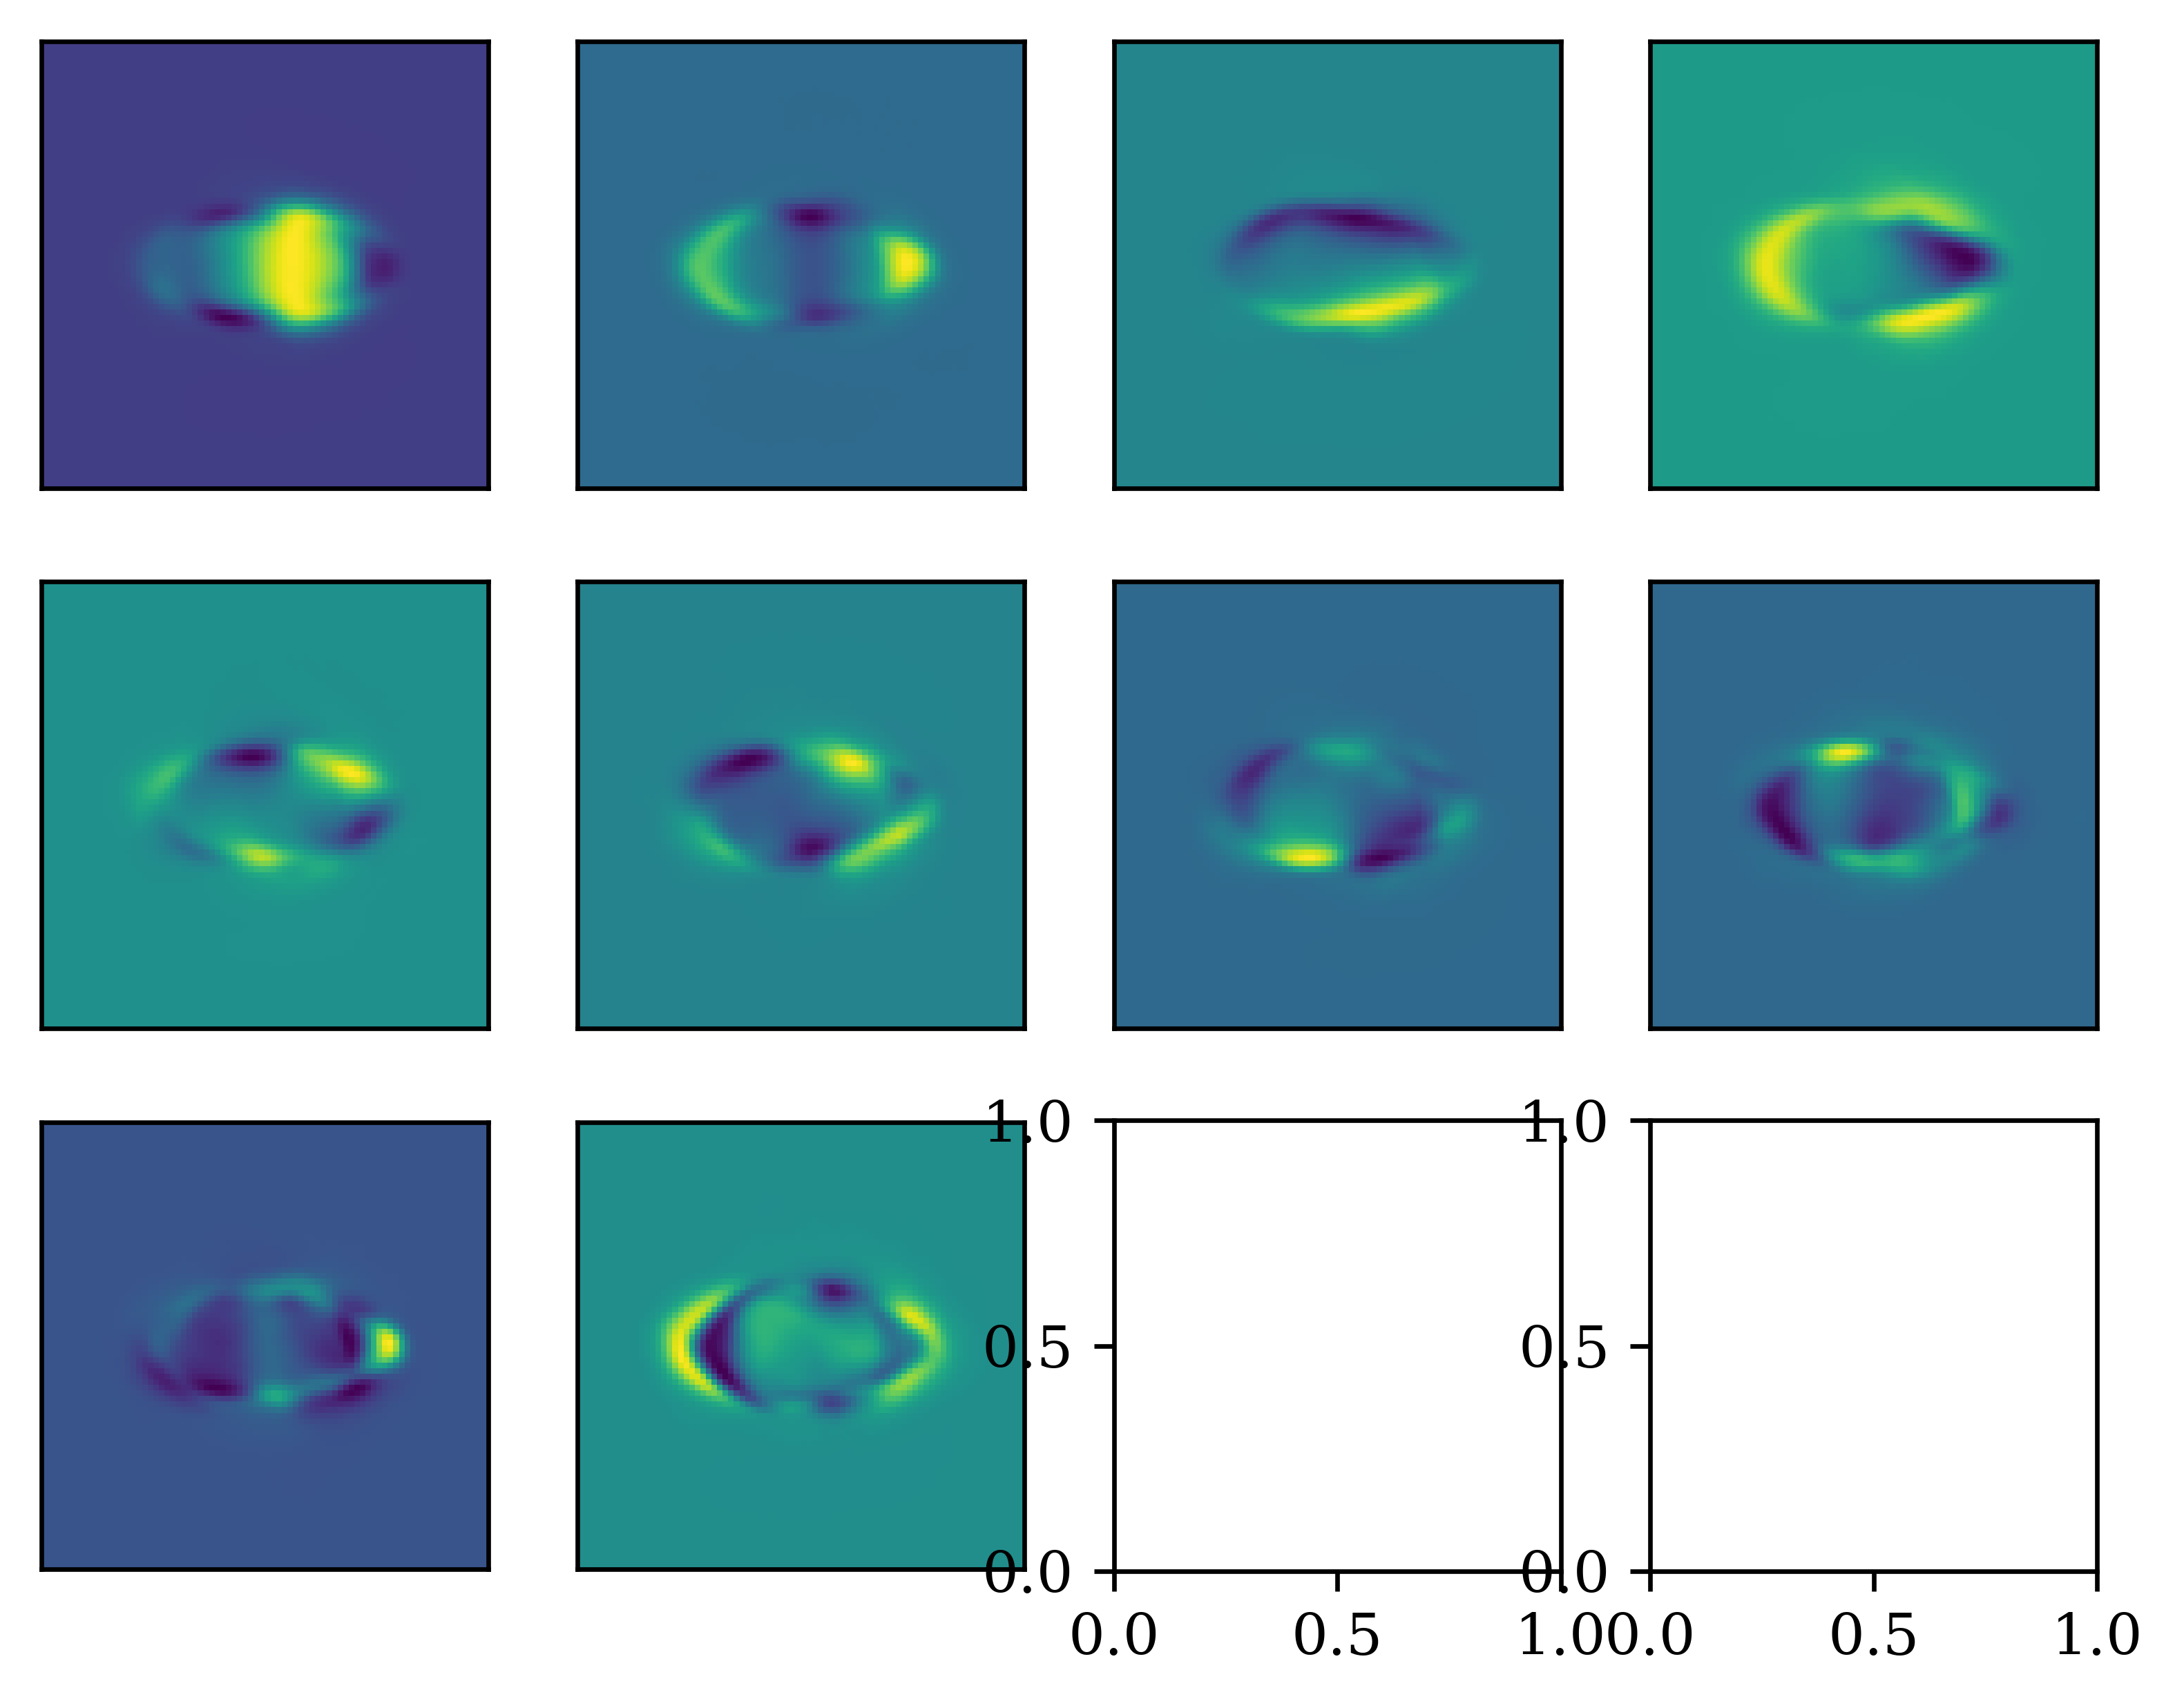

In [5]:
fig, ax = plt.subplots(3, 4)
for a, comp in zip(ax.flat, x_pca.components_):
    a.imshow(comp.reshape(80, 80))
    a.set(yticks=[], xticks=[])

In [6]:
x_pcs.shape

(15000, 10)

In [7]:
best_pred_pcs = PCA(n_components=50).fit_transform(best_pred_x.reshape(len(best_pred_x), -1))
best_pred_pcs = StandardScaler().fit_transform(best_pred_pcs)

In [17]:
# mdl = ElasticNet(alpha=0.02, l1_ratio=0.9, max_iter=2000)
mdl = LinearRegression()
mdl.fit(best_pred_pcs, x_pcs)

LinearRegression()

In [18]:
mse = mean_squared_error(x_pcs, mdl.predict(best_pred_pcs))

In [19]:
mdl.score(best_pred_pcs, x_pcs)

0.691127845698692

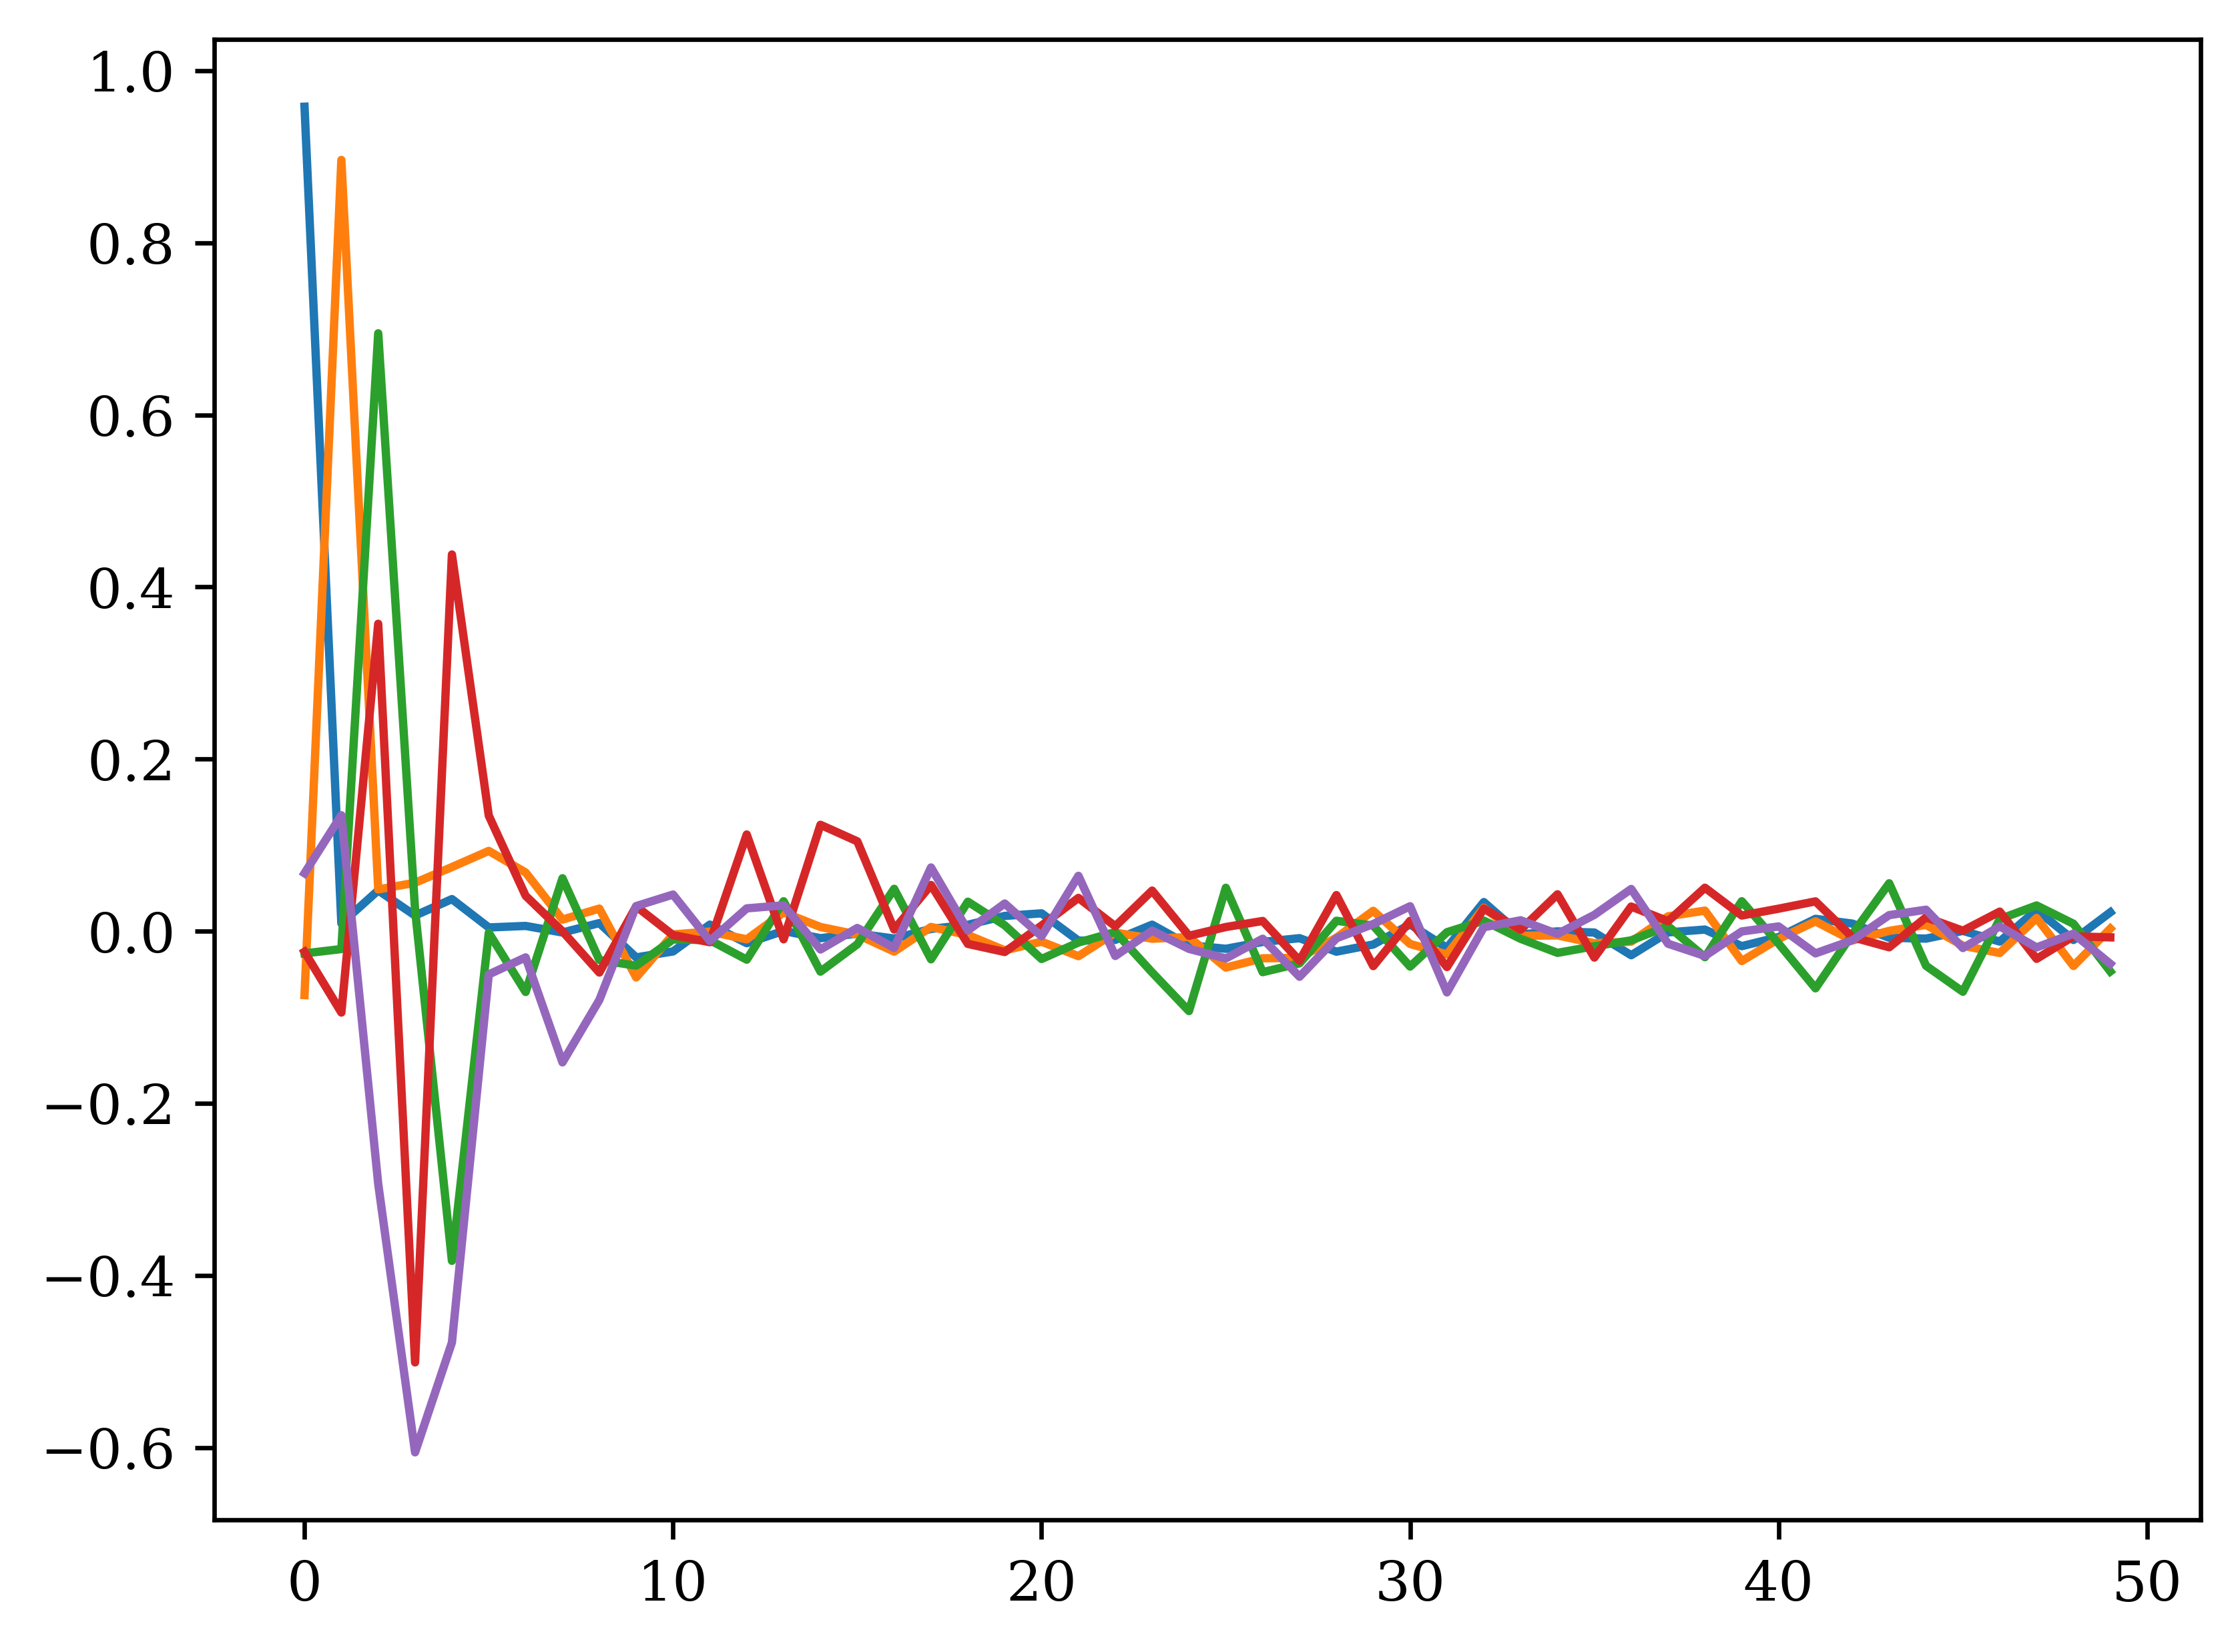

In [20]:
plt.plot(mdl.coef_[0])
plt.plot(mdl.coef_[1])
plt.plot(mdl.coef_[2])
plt.plot(mdl.coef_[3])
plt.plot(mdl.coef_[4])

In [21]:
pcs_pred = mdl.predict(best_pred_pcs)

<Axes: >

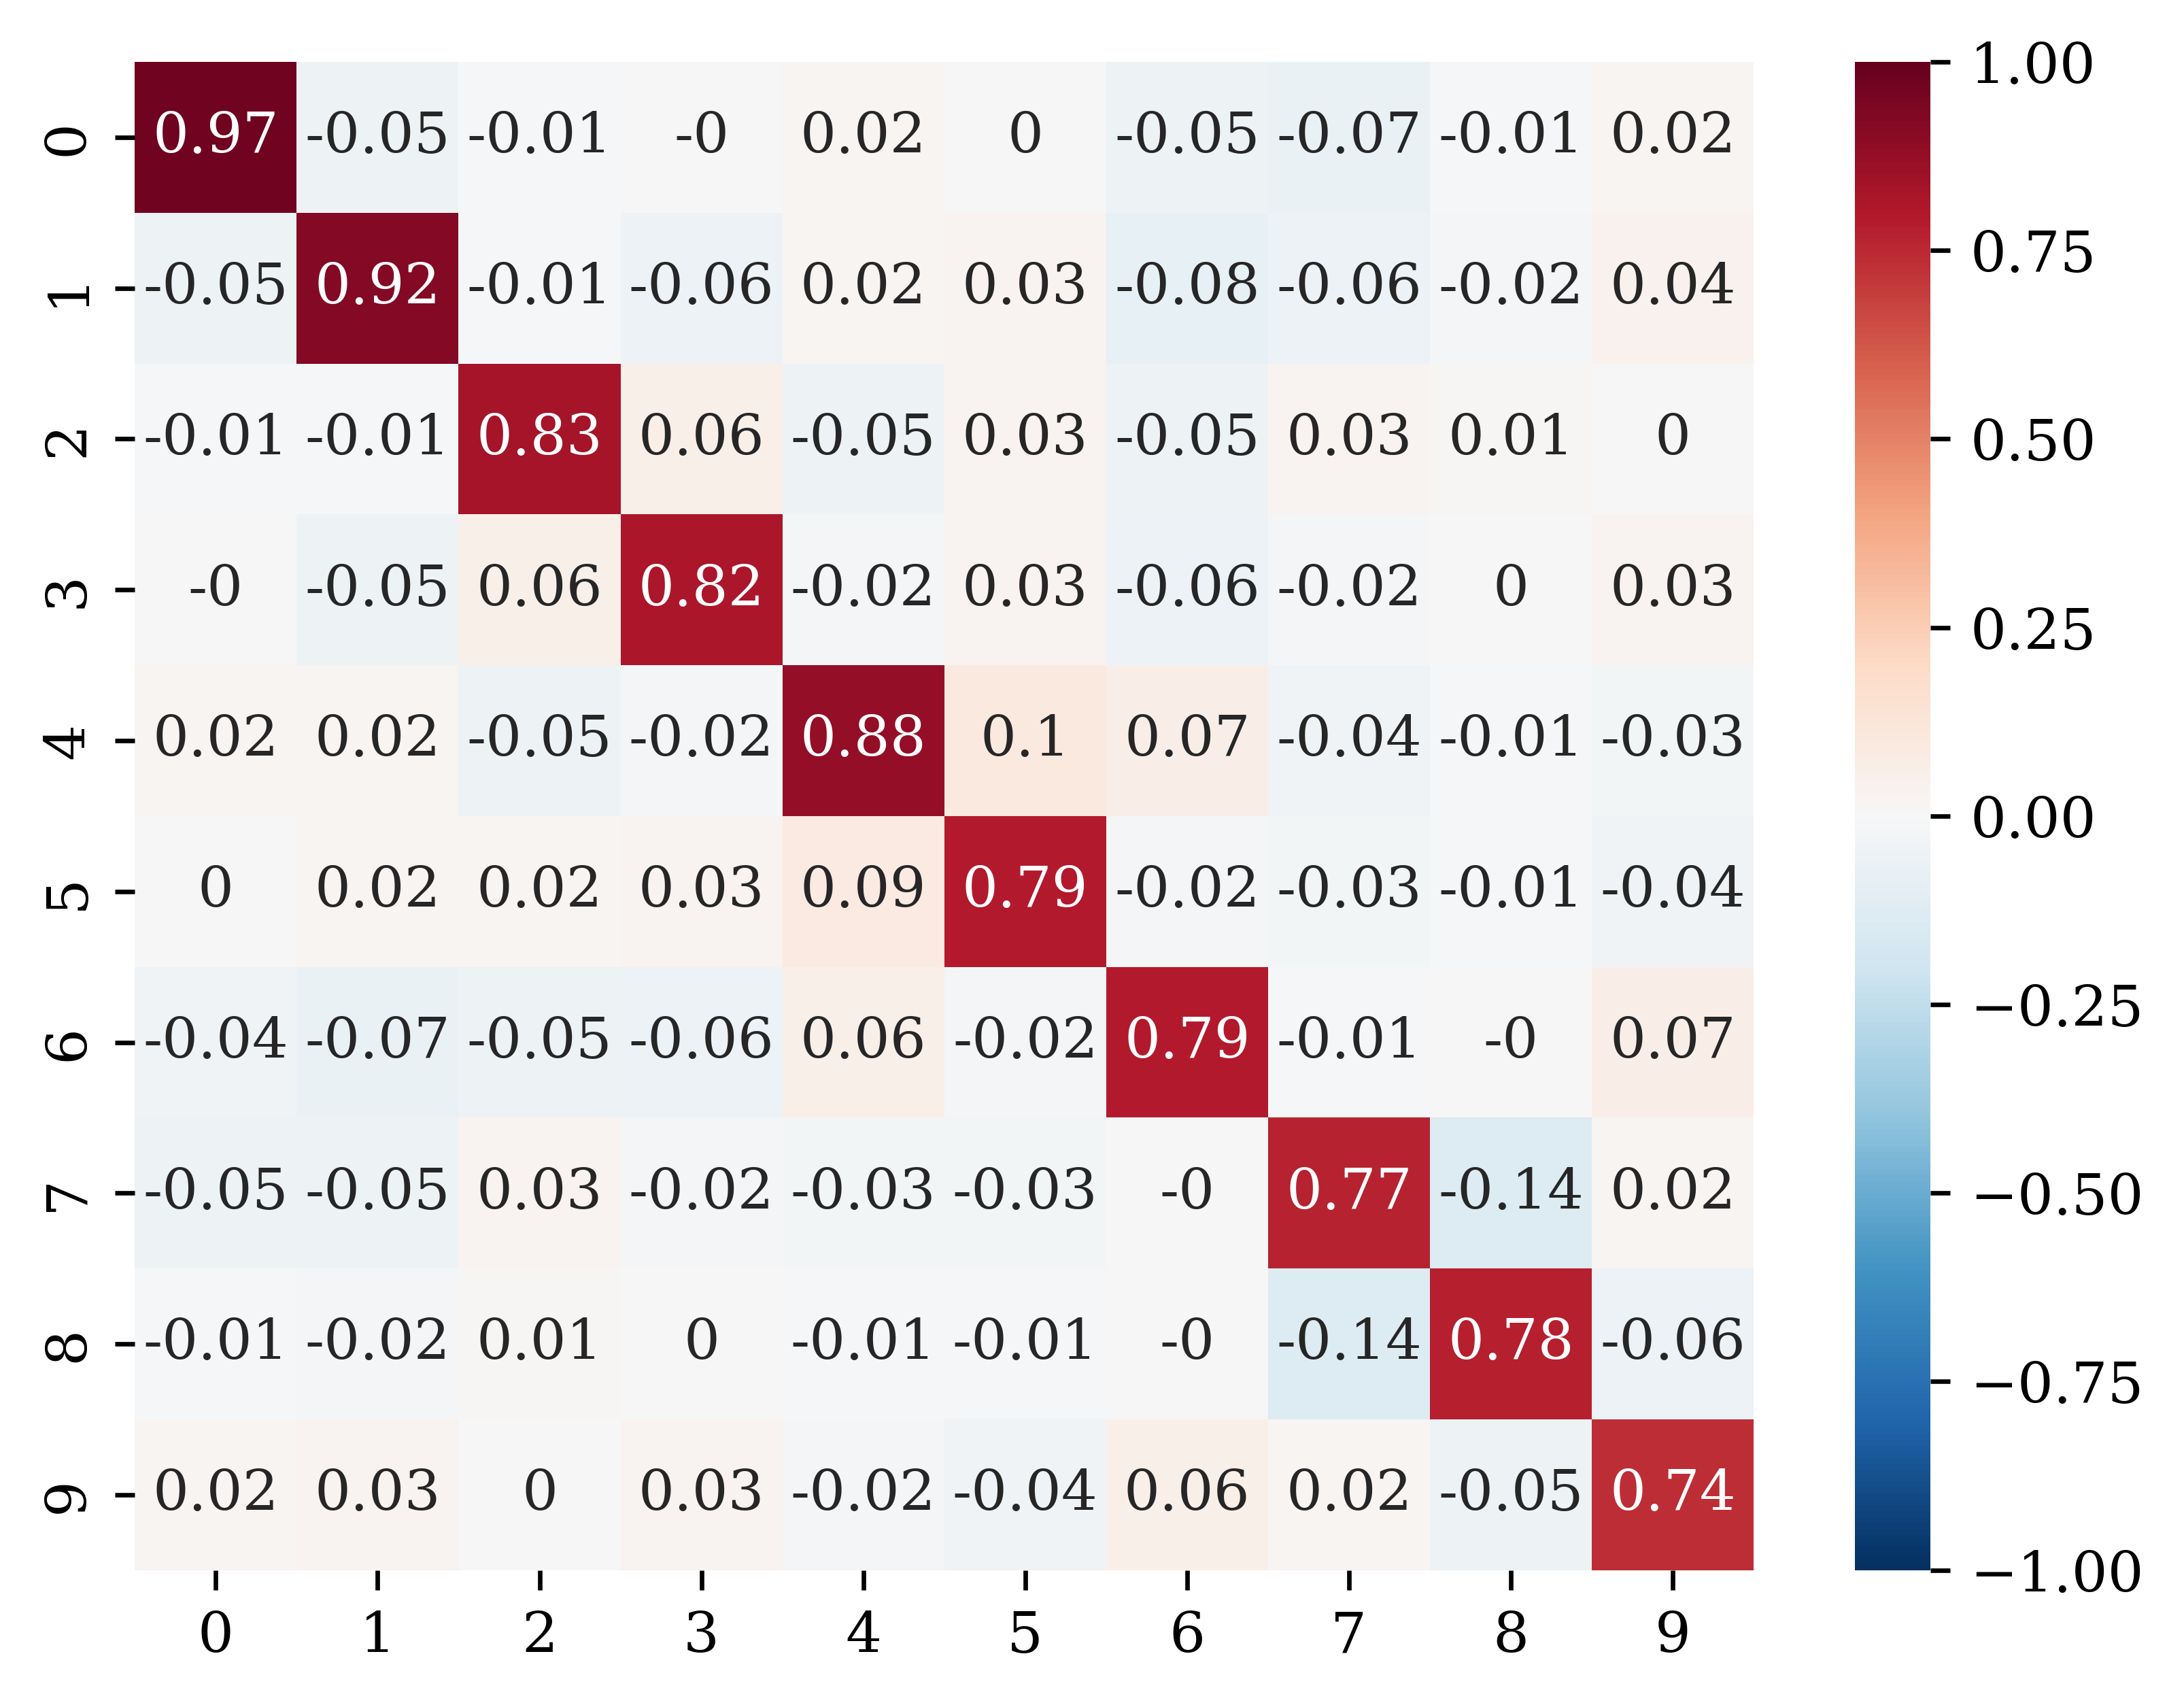

In [22]:
cc = np.round(np.corrcoef(pcs_pred.T, x_pcs.T)[10:, :10], 2)
sns.heatmap(cc, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)

In [23]:
np.diag(cc).mean()

0.829

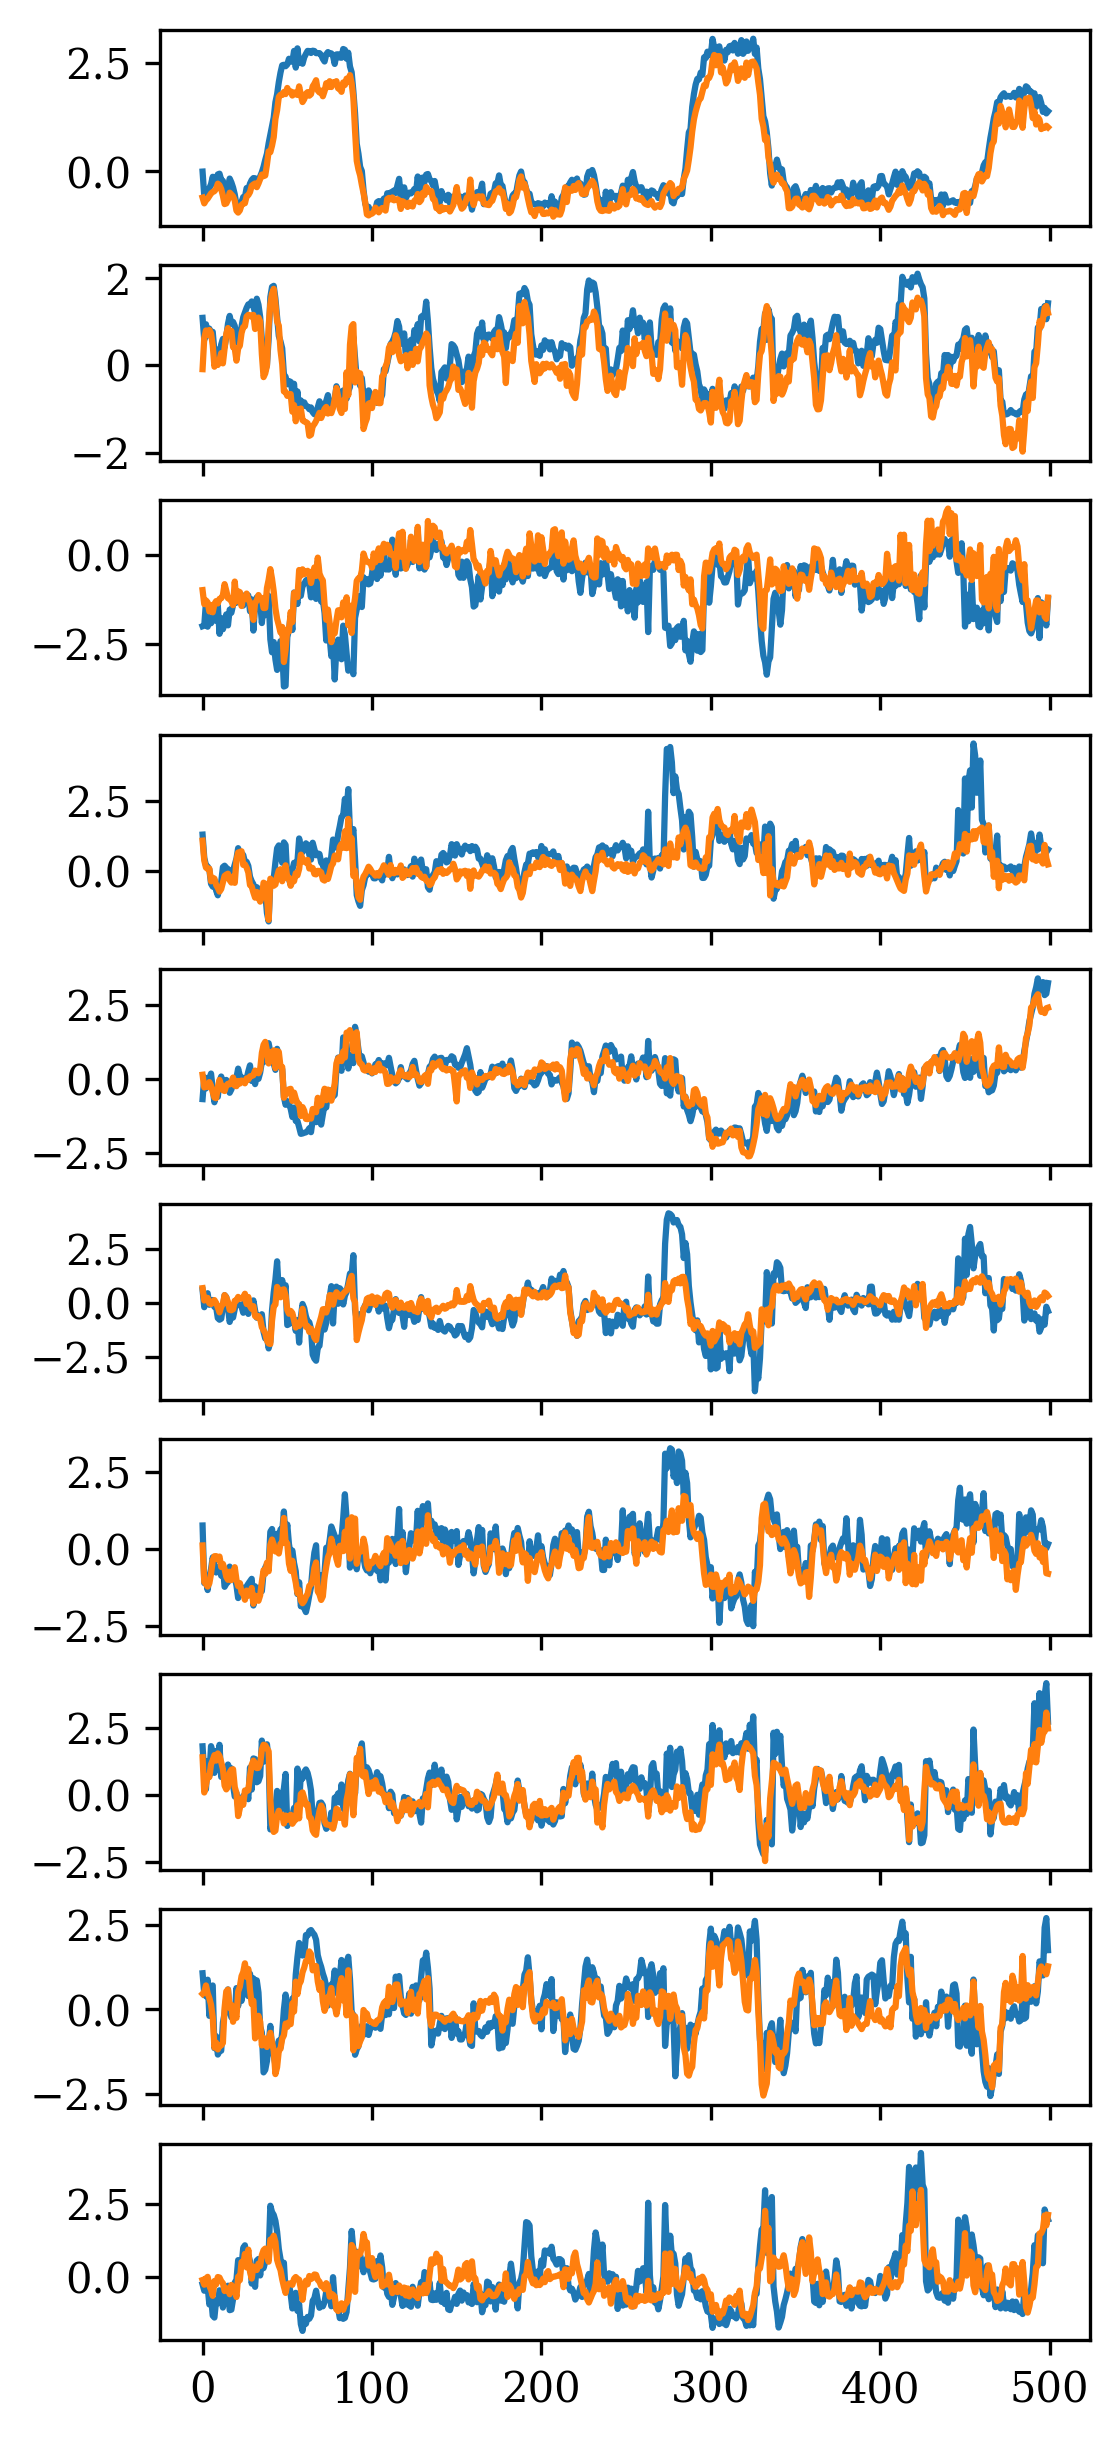

In [24]:
fig, ax = plt.subplots(10, 1, sharex=True, figsize=(4, 10))
fig.dpi = 150
for ind, a in enumerate(ax.flat):
    a.plot(x_pcs[:500, ind])
    a.plot(pcs_pred[:500, ind])